# Preliminary analysis

## Dataset Description

BigOBench is a dataset used in the field of Natural Language Processing. This dataset is desgined for three tasks:
1. Predicting time-space complexities of existing solutions.
2. Generating new code that meets specified complexity requirements.
3. Ranking solutions against human-written code with similar complexity profiles.

The dataset comprises a set of 3,105 coding problems and 1,190,250 solutions written in Python. 

## Loading BigOBench

The dataset includes 5 files JSONL:
1. problem_and_human_solutions_list.jsonl
2. complexity_labels_light.jsonl
3. complexity_labels_full.jsonl
4. time_complexity_test_set.jsonl
5. space_complexity_test_set.jsonl

- *problem_and_human_solutions_list.jsonl* includes all the problem descriptions and the corresponding solutions.
- *complexity_labels_light.jsonl* and *complexity_labels_full.jsonl* include the time complexity and the space complexity for each solutions, the latter one includes more information about runtime and memory footprint measures. 
- *time_complexity_test_set.jsonl* and *space_complexity_test_set.jsonl* include part of the problems with their corresponding solutions from  problem_and_human_solutions_list.jsonl and used for testing the model. 

In the preliminary analysis we focus mainly on *problem_and_human_solutions_list.jsonl* and *complexity_labels_light.jsonl*, since they provide the required information for performing our tasks. 

In the following code segments we import the two mentioned JSON files to start our preliminary analysis. 

In [2]:
from huggingface_hub import hf_hub_download
import json
import pandas as pd
from tqdm import tqdm
import json
import os
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import string
import re
import seaborn as sns
import pandas as pd
import collections
import numpy as np
import collections
from wordcloud import WordCloud
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk import FreqDist
import tokenize
import io
from collections import Counter

regex_punctuation = '[' + string.punctuation + ']'

/Users/chiaranguyen/.ai-navigator/micromamba/envs/metal/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/chiaranguyen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


We download the files from the BigOBench repository and load them into a pandas dataframe. 

In [3]:
# Download the dataset from Hugging Face Hub
file_path_1 = hf_hub_download(
    repo_id="facebook/BigOBench",
    filename="data/problem_and_human_solutions_list.jsonl",
    repo_type="dataset"
)
 
# Read the JSONL file and convert it to a DataFrame
df_problem_and_human_solutions_list = []
with open(file_path_1, "r", encoding="utf-8") as f:
    for line in f:
        try:
            df_problem_and_human_solutions_list.append(json.loads(line))
        except json.JSONDecodeError as e:
            print("Erorr JSON:", e)
 
print("Number of rows in problem_and_human_solutions_list:", len(df_problem_and_human_solutions_list))

df_problem_and_human_solutions_list = pd.DataFrame(df_problem_and_human_solutions_list)

Number of rows in problem_and_human_solutions_list: 3105


In [4]:
# Download the second dataset from Hugging Face Hub
file_path_2 = hf_hub_download(
    repo_id="facebook/BigOBench",
    filename="data/complexity_labels_light.jsonl",
    repo_type="dataset"
)

# Read the JSONL file and convert it to a DataFrame
df_complexity_labels_light = []
with open(file_path_2, "r", encoding="utf-8") as f:
    for line in f:
        try:
            df_complexity_labels_light.append(json.loads(line))
        except json.JSONDecodeError as e:
            print("Erorr JSON:", e)
 
print("Number of rows in complexity_labels_light:", len(df_complexity_labels_light))

df_complexity_labels_light = pd.DataFrame(df_complexity_labels_light)


Number of rows in complexity_labels_light: 1190250


We inspect the two dataframes for looking at the column names and types.

In [37]:
df_problem_and_human_solutions_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3105 entries, 0 to 3104
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   problem_id                    3105 non-null   object 
 1   problem_name                  3105 non-null   object 
 2   description                   3105 non-null   object 
 3   correct_solution_list         3105 non-null   object 
 4   data_source                   3105 non-null   object 
 5   source_specific_limits        3105 non-null   object 
 6   codeforces_specific_metadata  3105 non-null   object 
 7   tests                         3105 non-null   object 
 8   human_accuracy_rate           3105 non-null   float64
 9   dataclass                     3105 non-null   object 
 10  complexity_framework          3105 non-null   object 
dtypes: float64(1), object(10)
memory usage: 267.0+ KB


In [38]:
df_complexity_labels_light.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1190250 entries, 0 to 1190249
Data columns (total 7 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   problem_id                 1190250 non-null  object 
 1   problem_name               1190250 non-null  object 
 2   solution_id                1190250 non-null  object 
 3   time_complexity_inferred   1042842 non-null  object 
 4   space_complexity_inferred  1041579 non-null  object 
 5   time_curve_coefficient     1042647 non-null  float64
 6   space_curve_coefficient    1004713 non-null  float64
dtypes: float64(2), object(5)
memory usage: 63.6+ MB


As we can see, there are 11 columns for *df_problem_and_human_solutions_list* and 7 columns for *df_complexity_labels_light*. The types are object or float number.

Some columns in *df_problem_and_human_solutions_list* contain a dictionary, thus we extract the keys of these dictionaries in order to further explore our analysis and look for additional information. 

In [128]:
# Extract attributes from the columns of df_problem_and_human_solutions_list
for col in df_problem_and_human_solutions_list.columns:
    col_keys = set()
    for cell in df_problem_and_human_solutions_list[col]:
        if isinstance(cell, dict):
            col_keys.update(cell.keys())
        elif isinstance(cell, list):
            for item in cell:
                if isinstance(item, dict):
                    col_keys.update(item.keys())
    if col_keys:
        print(f"Column '{col}' has attributes", col_keys)

Column 'description' has attributes {'text', 'is_description_translated', 'untranslated_text'}
Column 'correct_solution_list' has attributes {'solution_code', 'solution_id'}
Column 'source_specific_limits' has attributes {'time_limit', 'memory_limit_bytes'}
Column 'codeforces_specific_metadata' has attributes {'cf_index', 'difficulty', 'cf_points', 'cf_rating', 'cf_tags', 'cf_contest_id'}
Column 'tests' has attributes {'generated_tests', 'public_tests', 'private_tests'}
Column 'dataclass' has attributes {'number_inputs', 'input_type_list', 'dataclass_code'}
Column 'complexity_framework' has attributes {'space_complexity_fail_rate', 'measures_set_id_to_input_properties', 'time_or_space_complexity_fail_rate', 'time_complexity_fail_rate'}


## Missing values

We inspect if there are any missing values in the two dataframes.
We can see that there are some missing values in the #df_complexity_labels_light* dataframe, but not in the *df_problem_and_human_solutions_list* dataframe.
In the *df_complexity_labels_light* dataframe, the columns with missing values are:
- time_complexity_inferred
- space_complexity_inferred
- time_curve_coefficient
- space_curve_coefficient


In [133]:
missing_columns = df_problem_and_human_solutions_list.columns[df_problem_and_human_solutions_list.isnull().any()].to_list()
print("Missing columns in df_problem_and_human_solutions_list:", missing_columns)
# Check for missing values in the DataFrame
missing_values = df_problem_and_human_solutions_list.isnull().sum()
print("Missing values in df_problem_and_human_solutions_list:\n", missing_values[missing_values > 0])

Missing columns in df_problem_and_human_solutions_list: []
Missing values in df_problem_and_human_solutions_list:
 Series([], dtype: int64)


In [132]:
# Find the columns with missing values in df_complexity_labels_light
missing_columns = df_complexity_labels_light.columns[df_complexity_labels_light.isnull().any()].tolist()
print("Columns with missing values in df_complexity_labels_light:", missing_columns)
# Check the number of missing values in each column
missing_counts = df_complexity_labels_light[missing_columns].isnull().sum()
print("Number of missing values in each column:")
print(missing_counts)



Columns with missing values in df_complexity_labels_light: ['time_complexity_inferred', 'space_complexity_inferred', 'time_curve_coefficient', 'space_curve_coefficient']
Number of missing values in each column:
time_complexity_inferred     147408
space_complexity_inferred    148671
time_curve_coefficient       147603
space_curve_coefficient      185537
dtype: int64


### Missing values in time and space complexity

For our aim, we decide to remove the solutions without the time or space complexities in *df_complexity_labels_light*. Thus, we filter both dataframes in order to remove this invalid solutions.

In [41]:
# Count the number of missing values in time_complexity_inferred and space_complexity_inferred
df_complexity_labels_light_filtered = df_complexity_labels_light.dropna(subset=["time_complexity_inferred", "space_complexity_inferred"])

# Consider only the rows where both time_complexity_inferred and space_complexity_inferred are not null
valid_solution_ids = set(df_complexity_labels_light_filtered['solution_id'])

# Total number of solutions before filtering
total_solutions_before = sum(len(lst) for lst in df_problem_and_human_solutions_list['correct_solution_list'])

# Filter the correct_solution_list based on valid solution IDs
def filter_solutions(solution_list):
    if isinstance(solution_list, list):
        return [sol for sol in solution_list if sol['solution_id'] in valid_solution_ids]
    else:
        return []

df_problem_and_human_solutions_list_filtered = df_problem_and_human_solutions_list.copy()
df_problem_and_human_solutions_list_filtered['correct_solution_list'] = df_problem_and_human_solutions_list_filtered['correct_solution_list'].apply(filter_solutions)

total_solutions_after = sum(len(lst) for lst in df_problem_and_human_solutions_list_filtered['correct_solution_list'])

# Count the number of solutions removed
solutions_removed = total_solutions_before - total_solutions_after
print(f"Number of solutions removed (invalid): {solutions_removed}")

# Count the number of problems with empty correct_solution_list
empty_correct_solution_count = df_problem_and_human_solutions_list_filtered['correct_solution_list'].apply(lambda x: len(x) == 0).sum()
print(f"Number of problems with empty correct_solution_list (i.e. with no solutions): {empty_correct_solution_count}")

# Delete problems with empty correct_solution_list
df_problem_and_human_solutions_list_filtered = df_problem_and_human_solutions_list_filtered[
    df_problem_and_human_solutions_list_filtered['correct_solution_list'].apply(lambda x: len(x) > 0)
]

# Print the number of solutions after filtering
print(f"Number of solutions after filtering: {sum(len(lst) for lst in df_problem_and_human_solutions_list_filtered['correct_solution_list'])}")

# Print the number of problems after filtering
print(f"Number of problems after filtering: {len(df_problem_and_human_solutions_list_filtered)}")

Number of solutions removed (invalid): 148672
Number of problems with empty correct_solution_list (i.e. with no solutions): 91
Number of solutions after filtering: 1041578
Number of problems after filtering: 3014


## Number of solutions per problem

Since we are interested in the solutions of the problems, we check how many solutions are available for each problem. We perform some basic statistics on the number of solutions per problem, like the mean, maximum and minimum number of solutions. 

We can see that there a very few problems with a single solution, while most of the problems have multiple solutions.

In [140]:
# Count the average number of solutions per problem in correct_solution_list column
def count_solutions(row):
    if isinstance(row, list):
        return len(row)
    return 0

# Averge number of solutions
average_num_solutions = df_problem_and_human_solutions_list_filtered['correct_solution_list'].apply(count_solutions).mean()
print(f"Average number of solutions per problem: {average_num_solutions:.2f}")
# Maximum number of solutions
max_num_solutions = df_problem_and_human_solutions_list_filtered['correct_solution_list'].apply(count_solutions).max()
print(f"Maximum number of solutions per problem: {max_num_solutions}")
# Minimum number of solutions
min_num_solutions = df_problem_and_human_solutions_list_filtered['correct_solution_list'].apply(count_solutions).min()
print(f"Minimum number of solutions per problem: {min_num_solutions}")
# Count the number of problems with multiple solutions
multiple_solutions_count = df_problem_and_human_solutions_list_filtered['correct_solution_list'].apply(lambda x: len(x) > 1).sum()
print(f"Number of problems with multiple solutions: {multiple_solutions_count}")
# Count the number of problems with a single solution
single_solution_count = df_problem_and_human_solutions_list_filtered['correct_solution_list'].apply(lambda x: len(x) == 1).sum()
print(f"Number of problems with a single solution: {single_solution_count}")

Average number of solutions per problem: 345.58
Maximum number of solutions per problem: 13374
Minimum number of solutions per problem: 1
Number of problems with multiple solutions: 3008
Number of problems with a single solution: 6


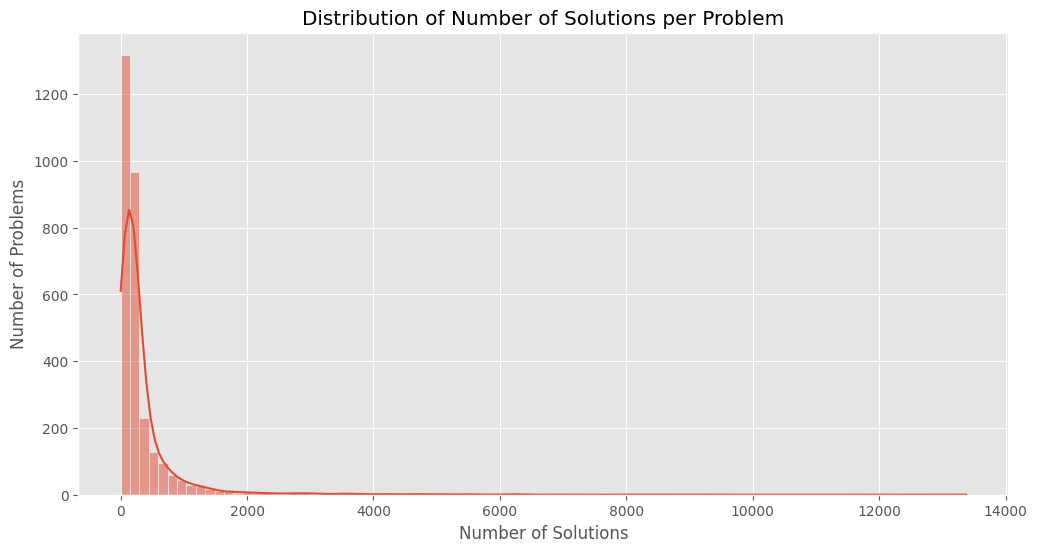

In [150]:
number_of_solutions_per_problem = df_problem_and_human_solutions_list_filtered['correct_solution_list'].apply(count_solutions)
num_bins = 90
interval_bin = (max(number_of_solutions_per_problem) - min(number_of_solutions_per_problem)) / num_bins

plt.figure(figsize=(12, 6))
sns.histplot(number_of_solutions_per_problem, bins=num_bins, kde=True)
plt.title('Distribution of Number of Solutions per Problem')
plt.xlabel('Number of Solutions')
plt.ylabel('Number of Problems')
plt.show()

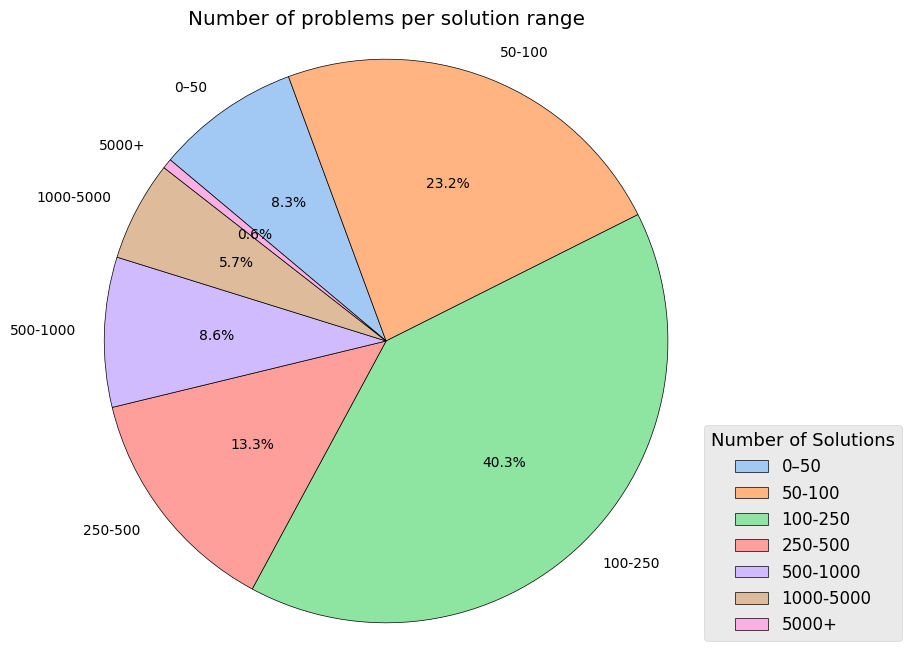

In [160]:
solution_counts = df_problem_and_human_solutions_list_filtered['correct_solution_list'].apply(count_solutions)

bins = [0, 50, 100, 250, 500, 1000, 5000, float('inf')]
labels = ['0–50', '50-100', '100-250', '250-500', '500-1000', '1000-5000', '5000+']

solution_ranges = pd.cut(solution_counts, bins=bins, labels=labels, right=False)
range_counts = solution_ranges.value_counts().sort_index()
colors = sns.color_palette('pastel')[0:len(labels)]

plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie(
    range_counts, 
    labels=range_counts.index, 
    autopct='%1.1f%%', 
    startangle=140,
    counterclock=False,
    colors=colors,
    wedgeprops={'edgecolor': 'black'}
)
plt.title('Number of problems per solution range')
plt.axis('equal')
plt.legend(
    wedges, 
    range_counts.index, 
    title="Number of Solutions", 
    loc='lower left', 
    bbox_to_anchor=(1, 0, 0.5, 1),
    fontsize=12,
    title_fontsize=13
)
plt.show()

## Description of the solutions

### Number of words in the problem description
We analyze the number of words in the problem description, comparing with and without punctuation and stop wwords. We perform some basic statistics on the number of words in the problem description, like the mean, maximum and minimum number of words. 

In [161]:
# Extract the text from the description column
def extract_text_from_description(description):
    if isinstance(description, dict):
        return description.get('text', '')
    return description

In [162]:
# Number of words in the description
def count_words(text):
    if isinstance(text, str):
        return len(re.findall(r'\w+', text))
    return 0

texts = df_problem_and_human_solutions_list['description'].apply(extract_text_from_description)
average_num_words = texts.apply(count_words).mean()
print(f"Average number of words in the description: {average_num_words:.2f}")
# Maximum number of words in the description
max_num_words = texts.apply(count_words).max()
print(f"Maximum number of words in the description: {max_num_words}")
# Minimum number of words in the description
min_num_words = texts.apply(count_words).min()
print(f"Minimum number of words in the description: {min_num_words}")

Average number of words in the description: 277.76
Maximum number of words in the description: 965
Minimum number of words in the description: 21


In [238]:
# Remove punctuation from the description and stop words
def remove_punctuation_and_stopwords(text):
    if isinstance(text, str):
        text = re.sub(regex_punctuation, '', text)
        text = text.lower()
        text = re.sub(r'\d+', '', text)
        stop_words = set(stopwords.words('english'))
        words = [word for word in text.split() if word not in stop_words]
        return ' '.join(words)
    return text

texts_cleaned = texts.apply(remove_punctuation_and_stopwords)
# Count the number of words in the cleaned description
average_num_words_cleaned = texts_cleaned.apply(count_words).mean()
print(f"Average number of words in the cleaned description: {average_num_words_cleaned:.2f}")
# Maximum number of words in the cleaned description
max_num_words_cleaned = texts_cleaned.apply(count_words).max()
print(f"Maximum number of words in the cleaned description: {max_num_words_cleaned}")
# Minimum number of words in the cleaned description
min_num_words_cleaned = texts_cleaned.apply(count_words).min()
print(f"Minimum number of words in the cleaned description: {min_num_words_cleaned}")

Average number of words in the cleaned description: 132.29
Maximum number of words in the cleaned description: 422
Minimum number of words in the cleaned description: 12


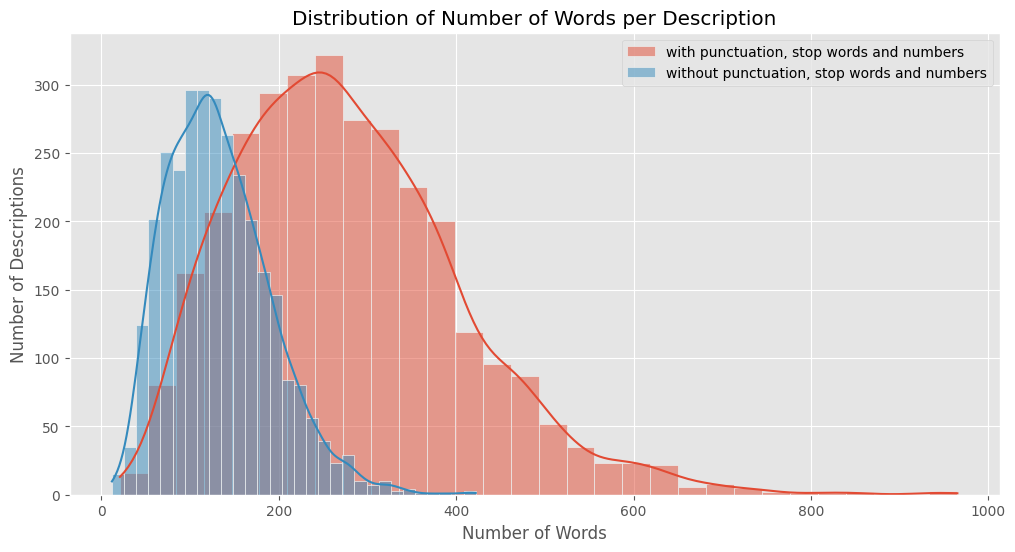

In [240]:
num_of_words_per_description = texts.apply(count_words)
num_of_words_per_description_cleaned = texts_cleaned.apply(count_words)
num_bins = 15
interval_bin = (max(num_of_words_per_description) - min(num_of_words_per_description)) / num_bins

plt.figure(figsize=(12, 6))
sns.histplot(num_of_words_per_description, bins=num_bins*2, kde=True, label='with punctuation, stop words and numbers') 
sns.histplot(num_of_words_per_description_cleaned, bins=num_bins*2, kde=True, label='without punctuation, stop words and numbers')
plt.title('Distribution of Number of Words per Description')
plt.xlabel('Number of Words')
plt.ylabel('Number of Descriptions')
plt.legend()
plt.show()

### Description Vocabulary
We analyze the vocabulary of the problem descriptions. 

In [18]:
# Collect all descriptions
all_descriptions = df_problem_and_human_solutions_list['description'].dropna().tolist()
# Extract text from descriptions
all_texts = [desc.get('text', '') for desc in all_descriptions]
# Join all texts into a single string
all_text = ' '.join(all_texts)
# Count the number of unique words in the vocabulary
unique_words = set(re.findall(r'\w+', all_text))
print(f"Number of unique words in vocabulary of descriptions: {len(unique_words)}")

Number of unique words in vocabulary of descriptions: 18037


In [19]:
# Remove punctuation, stop words, numbers, and lowercase the words
words_cleaned = []
for text in all_texts:
    text = re.sub(regex_punctuation, '', text)
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    stop_words = set(stopwords.words('english'))
    words = [word for word in text.split() if word not in stop_words]
    words_cleaned.extend(words)

unique_words_cleaned = set(words_cleaned)
print(f"Number of unique words in vocabulary of descriptions (without punctuation and stop words): {len(unique_words_cleaned)}")

Number of unique words in vocabulary of descriptions (without punctuation and stop words): 14447


In [221]:
# Print the most 50 common words
word_counts = Counter(words_cleaned)
most_common_words = word_counts.most_common(50)
print("Most common words in the descriptions:")
for word, count in most_common_words:
    print(f"{word}: {count}")

Most common words in the descriptions:
input: 13177
n: 11683
output: 11297
number: 7885
first: 6063
line: 5712
one: 5294
contains: 4791
print: 4409
integer: 4339
integers: 4104
second: 3696
two: 3234
example: 3209
b: 3174
test: 3062
x: 3000
given: 2846
string: 2713
k: 2661
examples: 2533
note: 2398
case: 2186
possible: 2020
ith: 1941
leq: 1932
following: 1911
single: 1903
a_: 1848
length: 1786
array: 1692
sequence: 1613
numbers: 1602
yes: 1529
a_i: 1411
find: 1397
answer: 1380
minimum: 1310
equal: 1296
order: 1240
c: 1165
third: 1146
maximum: 1133
sample: 1089
elements: 1084
exactly: 1072
time: 1056
lines: 1050
sum: 1037
cases: 1025


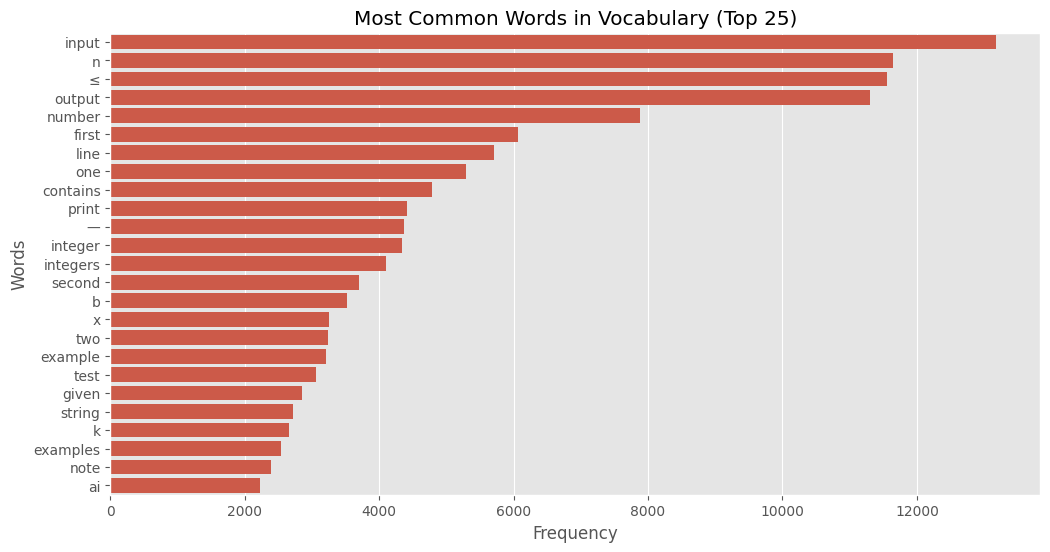

In [20]:
# Most common words in the vocabulary
def plot_most_common_words(words, num_words=20):
    word_counts = Counter(words)
    most_common = word_counts.most_common(num_words)
    words, counts = zip(*most_common)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x=list(counts), y=list(words))
    plt.title(f'Most Common Words in Vocabulary (Top {num_words})')
    plt.xlabel('Frequency')
    plt.ylabel('Words')
    plt.show()
plot_most_common_words(words_cleaned, num_words=25)

### Number of words per frequency in the problem description

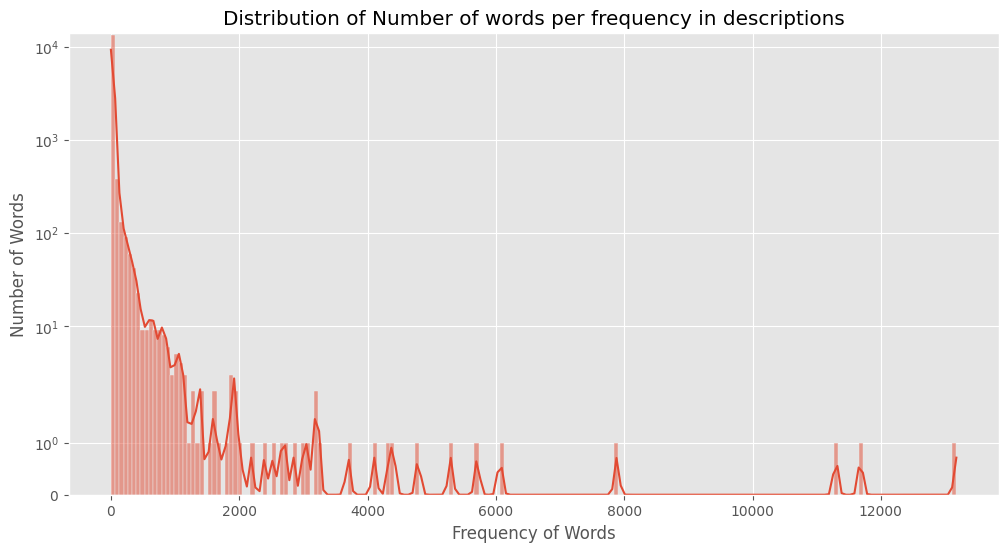

In [216]:
words_frequency = list(Counter(words_cleaned).values())
num_bins = 100
interval_bin = (max(words_frequency) - min(words_frequency)) / num_bins
plt.figure(figsize=(12, 6))
sns.histplot(words_frequency, bins=num_bins*2, kde=True)
plt.title('Distribution of Number of words per frequency in descriptions')
plt.xlabel('Frequency of Words')
plt.ylabel('Number of Words')
plt.yscale('symlog')
plt.show()


In [217]:
# Calculate the maximum words frequency
max_frequency = max(words_frequency)
print(f"Maximum frequency of words in descriptions: {max_frequency}")
# Calculate the minimum words frequency
min_frequency = min(words_frequency)
print(f"Minimum frequency of words in descriptions: {min_frequency}")
# Calculate the average words frequency
average_frequency = sum(words_frequency) / len(words_frequency)
print(f"Average frequency of words in descriptions: {average_frequency:.2f}")

Maximum frequency of words in descriptions: 13177
Minimum frequency of words in descriptions: 1
Average frequency of words in descriptions: 28.61


### Word Cloud of the problem description

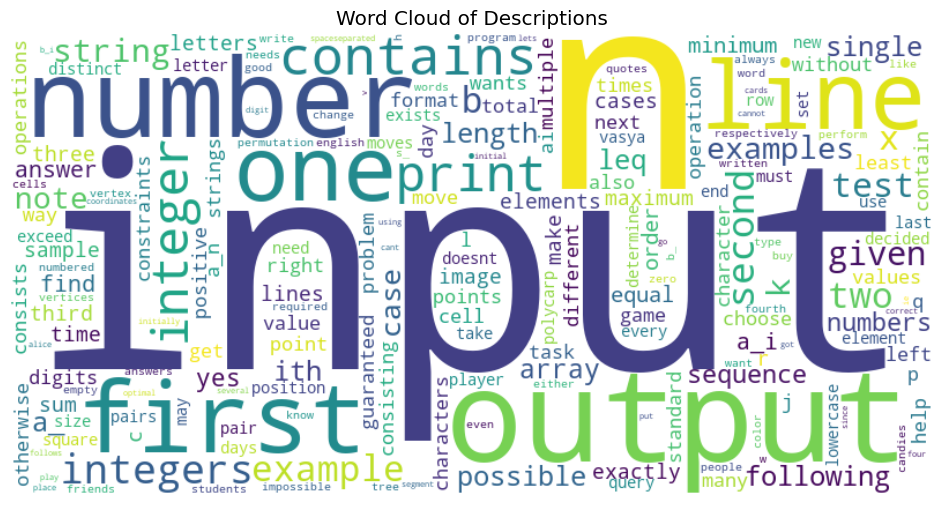

In [223]:
# Create a word cloud
word_counter = Counter(words_cleaned)
world_cloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counter)

plt.figure(figsize=(12, 6))
plt.imshow(world_cloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Descriptions')
plt.show()

### N-Grams of the problem description
We analyze the most common n-grams in the problem description. This can help us to understand the most common phrases and expressions used in the problem descriptions.

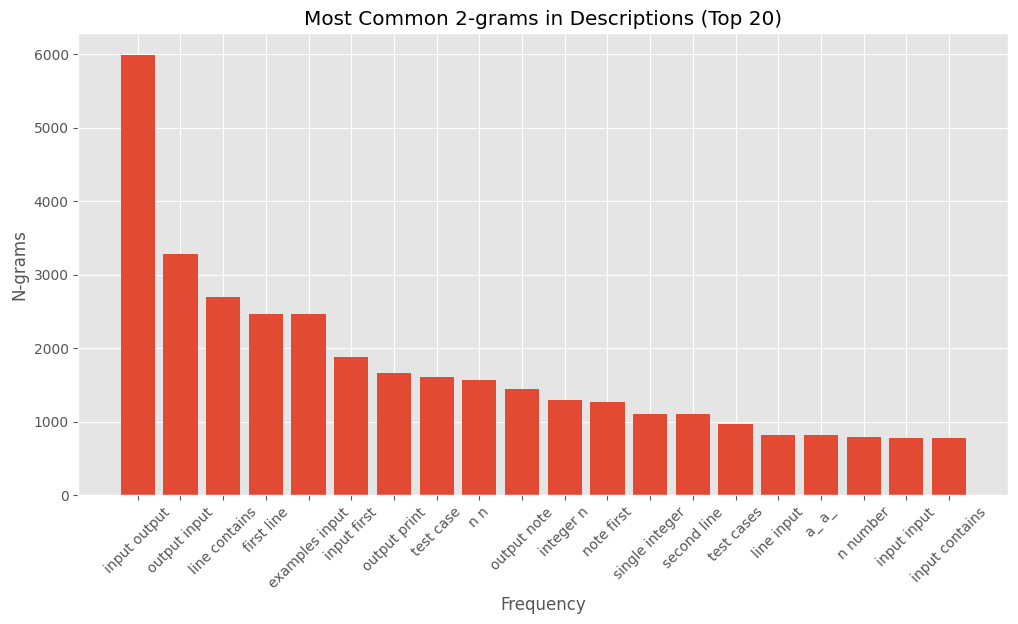

In [ ]:
# 2-grams
n = 2
tokenized_texts = texts_cleaned.apply(lambda x: x.split())

ngrams_list = []
for tokens in tokenized_texts:
    ngrams_in_text = list(ngrams(tokens, n))  # n-grams per singola descrizione
    ngrams_list.extend(ngrams_in_text) 
    
ngrams_counter = Counter(ngrams_list)

N = 20
most_common_ngrams = ngrams_counter.most_common(N)
ngram_tuples, counts = zip(*most_common_ngrams)
ngram_strings = [" ".join(ngram) for ngram in ngram_tuples]

plt.figure(figsize=(12, 6))
plt.bar(ngram_strings, counts)
plt.title(f'Most Common {n}-grams in Descriptions (Top {N})')
plt.xlabel('Frequency')
plt.ylabel(f'N-grams')
plt.xticks(rotation=45)
plt.show()


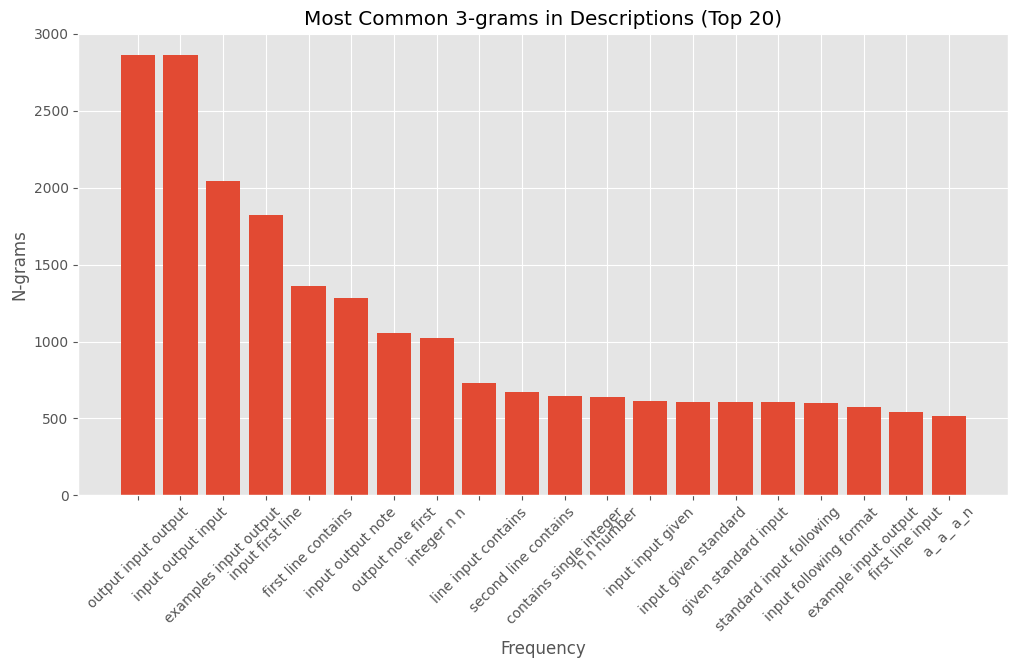

In [ ]:
# 3-grams
n = 3
tokenized_texts = texts_cleaned.apply(lambda x: x.split())

ngrams_list = []
for tokens in tokenized_texts:
    ngrams_in_text = list(ngrams(tokens, n))
    ngrams_list.extend(ngrams_in_text) 
    
ngrams_counter = Counter(ngrams_list)

N = 20
most_common_ngrams = ngrams_counter.most_common(N)
ngram_tuples, counts = zip(*most_common_ngrams)
ngram_strings = [" ".join(ngram) for ngram in ngram_tuples]

plt.figure(figsize=(12, 6))
plt.bar(ngram_strings, counts)
plt.title(f'Most Common {n}-grams in Descriptions (Top {N})')
plt.xlabel('Frequency')
plt.ylabel(f'N-grams')
plt.xticks(rotation=45)
plt.show()


### Duplicated descriptions
We check if there are any duplicated descriptions in the problem descriptions. We can see that there are some duplicated descriptions, but they are not very frequent.

In [218]:
# Unique text in the description
description_counts = texts.value_counts()
# Duplicate texts in the description
duplicate_descriptions = description_counts[description_counts > 1]

print("Number of unique descriptions:", len(description_counts))
print("Number of duplicated descriptions:", len(duplicate_descriptions))

Number of unique descriptions: 3031
Number of duplicated descriptions: 74


### Translated descriptions

By looking at the description column of *df_problem_and_human_solutions_list*, there is also a boolean value *is_description_translated*. If this value is set to True, there is the untranslated description of the problem. !CHECK

In [ ]:
# Check if the 'description' column is a string and convert it to a dictionary
if isinstance(df_problem_and_human_solutions_list['description'].iloc[0], str):
    df_problem_and_human_solutions_list['description'] = df_problem_and_human_solutions_list['description'].apply(json.loads)

# Check if is_description_translated is True
filtered_df = df_problem_and_human_solutions_list[df_problem_and_human_solutions_list['description'].apply(
    lambda x: isinstance(x, dict) and x.get('is_description_translated') is True
)]

print(f"Number of rows where is_description_translated is True: {len(filtered_df)}")

Number of rows where description['is_description_translated'] is True: 29


In [65]:
# Remove from description is_description_translated and untranslated_text
def remove_untranslated_text(description):
    if isinstance(description, dict):
        description.pop('is_description_translated', None)
        description.pop('untranslated_text', None)
    return description

df_problem_and_human_solutions_list['description'] = df_problem_and_human_solutions_list['description'].apply(remove_untranslated_text)

In [68]:
# Remove dict in description and keep only the text
df_problem_and_human_solutions_list['description'] = df_problem_and_human_solutions_list['description'].apply(extract_text_from_description)

## Code Solutions

### Number of words in the code solutions

In [43]:
# Extract the code from the solution column
def extract_code_from_solution(solution, other_data=None):
    if not isinstance(solution, list):
        return []

    rows = []
    for s in solution:
        code = s.get('solution_code', '')
        if code:
            row = {'solution_id': s.get('solution_id', ''), 'solution_code': code}
            if other_data:
                row.update(other_data)
            rows.append(row)
    return rows

In [44]:
# Extract the code from the solution column
extracted_codes = df_problem_and_human_solutions_list_filtered['correct_solution_list'].apply(extract_code_from_solution)

# Flatten the list of lists into a single list
df_codes = pd.DataFrame(
    [item for sublist in extracted_codes for item in sublist],
    columns=['solution_id', 'solution_code']
)

# Explode the DataFrame to have one row per solution code
df_codes = df_codes.explode('solution_code').reset_index(drop=True)


In [9]:
# Count the number of words in the code
def count_words_in_code(code):
    if isinstance(code, str):
        return len(re.findall(r'\w+', code))
    return 0

words_in_code = df_codes['solution_code'].apply(count_words_in_code)
# Count average number of words in the code
average_num_words_in_code = words_in_code.mean()
print(f"Average number of words in the code: {average_num_words_in_code:.2f}")
# Count maximum number of words in the code
max_num_words_in_code = words_in_code.max()
print(f"Maximum number of words in the code: {max_num_words_in_code}")
# Count minimum number of words in the code
min_num_words_in_code = words_in_code.min()
print(f"Minimum number of words in the code: {min_num_words_in_code}")

Average number of words in the code: 62.22
Maximum number of words in the code: 16423
Minimum number of words in the code: 2


In [10]:
# Remove punctuation from the code and numbers
def remove_punctuation_and_numbers(code):
    if isinstance(code, str):
        code = re.sub(regex_punctuation, '', code)
        code = re.sub(r'\d+', '', code)
        return code
    return code

df_codes_cleaned = df_codes.copy()
df_codes_cleaned['solution_code'] = df_codes_cleaned['solution_code'].apply(remove_punctuation_and_numbers)

# Count the average number of words in the cleaned code
average_num_words_in_code_cleaned = df_codes_cleaned['solution_code'].apply(count_words_in_code).mean()
print(f"Average number of words in the cleaned code: {average_num_words_in_code_cleaned:.2f}")
# Count the maximum number of words in the cleaned code
max_num_words_in_code_cleaned = df_codes_cleaned['solution_code'].apply(count_words_in_code).max()
print(f"Maximum number of words in the cleaned code: {max_num_words_in_code_cleaned}")
# Count the minimum number of words in the cleaned code
min_num_words_in_code_cleaned = df_codes_cleaned['solution_code'].apply(count_words_in_code).min()
print(f"Minimum number of words in the cleaned code: {min_num_words_in_code_cleaned}")

Average number of words in the cleaned code: 34.40
Maximum number of words in the cleaned code: 4577
Minimum number of words in the cleaned code: 1


In [11]:
# Count the number of lines in the code
def count_lines_in_code(code):
    if isinstance(code, str):
        return len(code.split('\n'))
    return 0

lines_in_code = df_codes['solution_code'].apply(count_lines_in_code)
# Count average number of lines in the code
average_num_lines_in_code = lines_in_code.mean()
print(f"Average number of lines in the code: {average_num_lines_in_code:.2f}")
# Count maximum number of lines in the code
max_num_lines_in_code = lines_in_code.max()
print(f"Maximum number of lines in the code: {max_num_lines_in_code}")
# Count minimum number of lines in the code
min_num_lines_in_code = lines_in_code.min()
print(f"Minimum number of lines in the code: {min_num_lines_in_code}")

Average number of lines in the code: 18.74
Maximum number of lines in the code: 4131
Minimum number of lines in the code: 1


### Solutions Vocabulary

In [12]:
# Collect all codes
all_codes = df_codes['solution_code'].dropna().tolist()
# Join all codes into a single string
all_code = ' '.join(all_codes)
# Count the number of unique words in the vocabulary
unique_words_code = set(re.findall(r'\w+', all_code))
print(f"Number of unique words in vocabulary of codes: {len(unique_words_code)}")

Number of unique words in vocabulary of codes: 308726


In [13]:
# Remove punctuation, stop words, numbers, and lowercase the words
words_code_cleaned = []
for code in all_codes:
    code = re.sub(regex_punctuation, '', code)
    code = code.lower()
    code = re.sub(r'\d+', '', code)
    stop_words = set(stopwords.words('english'))
    words = [word for word in code.split() if word not in stop_words]
    words_code_cleaned.extend(words)
unique_words_code_cleaned = set(words_code_cleaned)
print(f"Number of unique words in vocabulary of codes (without punctuation and stop words): {len(unique_words_code_cleaned)}")


Number of unique words in vocabulary of codes (without punctuation and stop words): 1235003


In [14]:
# Print the most 50 common words
word_counts_code = Counter(words_code_cleaned)
most_common_words_code = word_counts_code.most_common(50)
print("Most common words in the codes:")
for word, count in most_common_words_code:
    print(f"{word}: {count}")

Most common words in the codes:
n: 1081787
else: 887885
x: 570688
def: 507105
return: 482510
b: 468580
intinput: 436223
inputsplit: 418339
import: 394774
rangen: 367160
c: 343545
k: 332409
ans: 316020
print: 308433
j: 265502
input: 253418
l: 249871
elif: 228968
break: 214213
range: 200700
r: 177891
printyes: 169026
printno: 163920
true: 151483
p: 151183
count: 148440
main: 142907
mapint: 139055
nintinput: 137034
listmapint: 123668
false: 119496
ai: 107432
printans: 104818
math: 101872
sys: 100210
res: 99415
ranget: 99100
rangeintinput: 96308
f: 83540
cnt: 75054
si: 74123
lambda: 70903
flag: 70150
q: 67121
arr: 66121
v: 65155
num: 65055
w: 63963
ab: 59956
z: 59361


In [24]:
# Remove single characters
words_code_no_single_characters = [word for word in words_code_cleaned if len(word) > 1]

most_common_words_code_no_single_characters = Counter(words_code_no_single_characters).most_common(50)
print("Most common words in the codes (without single characters):")
for word, count in most_common_words_code_no_single_characters:
    print(f"{word}: {count}")


Most common words in the codes (without single characters):
else: 887885
def: 507105
return: 482510
intinput: 436223
inputsplit: 418339
import: 394774
rangen: 367160
ans: 316020
print: 308433
input: 253418
elif: 228968
break: 214213
range: 200700
printyes: 169026
printno: 163920
true: 151483
count: 148440
main: 142907
mapint: 139055
nintinput: 137034
listmapint: 123668
false: 119496
ai: 107432
printans: 104818
math: 101872
sys: 100210
res: 99415
ranget: 99100
rangeintinput: 96308
cnt: 75054
si: 74123
lambda: 70903
flag: 70150
arr: 66121
num: 65055
ab: 59956
continue: 57707
collections: 57108
name: 55805
intx: 54908
mapintinputsplit: 52143
li: 51353
listmapintinputsplit: 45931
printn: 45591
mod: 45548
sum: 43444
tintinput: 41564
temp: 40938
prints: 40763
end: 40275


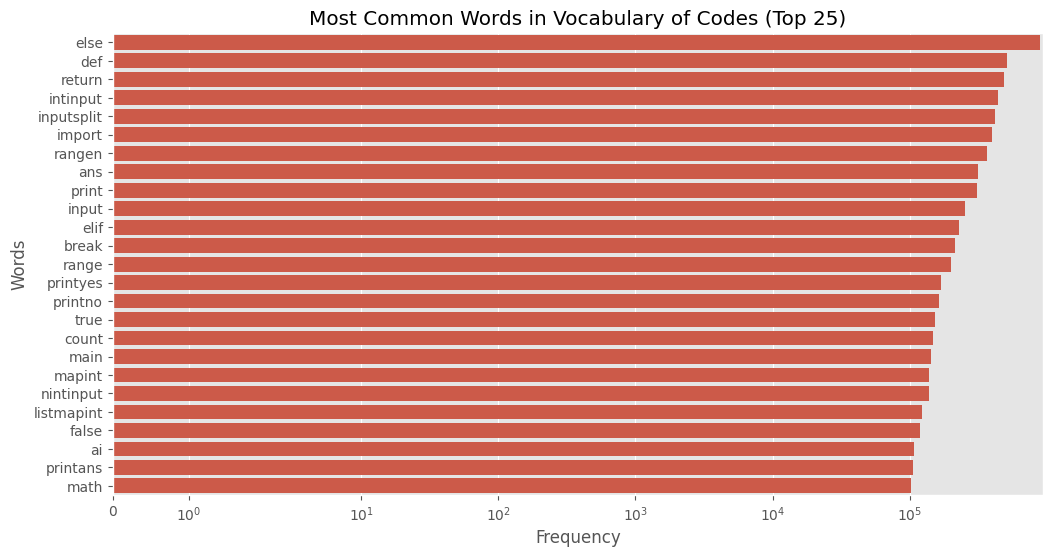

In [25]:
# Most common words in the vocabulary
def plot_most_common_words_code(words, num_words=20):
    word_counts = Counter(words)
    most_common = word_counts.most_common(num_words)
    words, counts = zip(*most_common)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x=list(counts), y=list(words))
    plt.title(f'Most Common Words in Vocabulary of Codes (Top {num_words})')
    plt.xlabel('Frequency')
    plt.ylabel('Words')
    plt.xscale('symlog')
    plt.show()
    
plot_most_common_words_code(words_code_no_single_characters, num_words=25)

### Number of words per frequency in the code solutions
We analyze the most common words in the code solutions. This can help us to understand the most common words used in the code solutions.

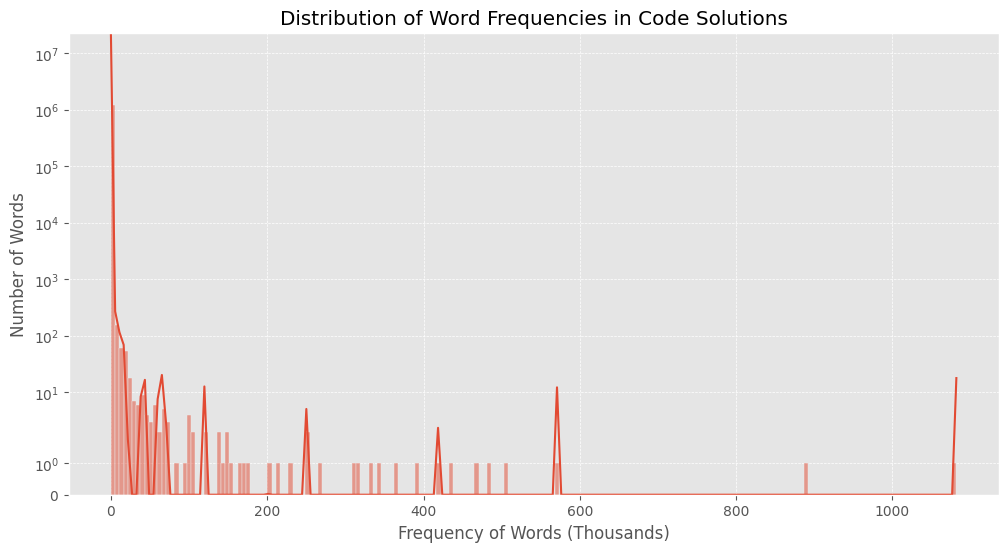

In [38]:
words_code_frequency = list(Counter(words_code_cleaned).values())
words_code_frequency_k = [freq / 1000 for freq in words_code_frequency]

num_bins = 100
plt.figure(figsize=(12, 6))
sns.histplot(words_code_frequency_k, bins=num_bins*2, kde=True)
plt.title('Distribution of Word Frequencies in Code Solutions')
plt.xlabel('Frequency of Words (Thousands)')
plt.ylabel('Number of Words')
plt.yscale('symlog')
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.show()

In [45]:
# Calculate the average words frequency
average_frequency_code = sum(words_code_frequency) / len(words_code_frequency)
print(f"Average frequency of words in codes: {average_frequency_code:.2f}")
# Calculate the maximum words frequency
max_frequency_code = max(words_code_frequency)
print(f"Maximum frequency of words in codes: {max_frequency_code}")
# Calculate the minimum words frequency
min_frequency_code = min(words_code_frequency)
print(f"Minimum frequency of words in codes: {min_frequency_code}") 

Average frequency of words in codes: 20.59
Maximum frequency of words in codes: 1081787
Minimum frequency of words in codes: 1


### Word Cloud of the code solutions

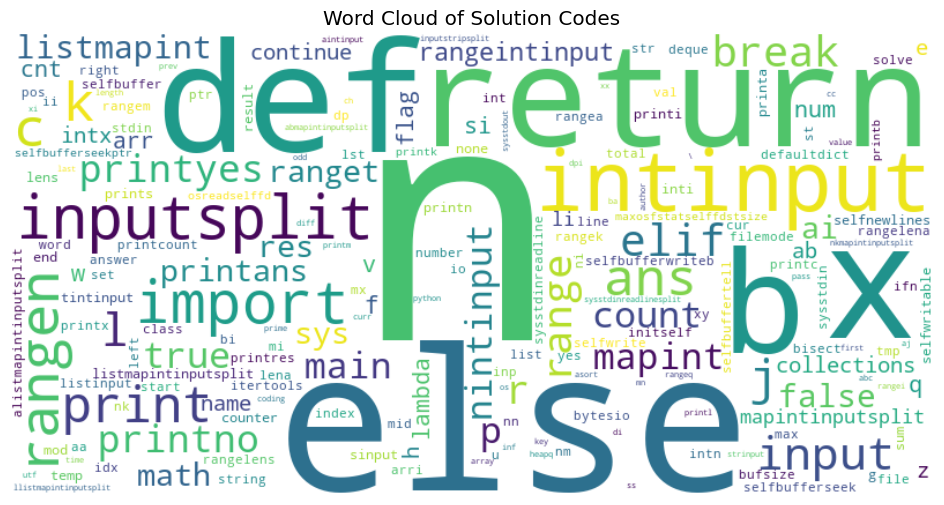

In [39]:
# Create a word cloud
word_code_counter = Counter(words_code_cleaned)
world_cloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_code_counter)

plt.figure(figsize=(12, 6))
plt.imshow(world_cloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Solution Codes')
plt.show()

### Duplicated code solutions
We check if there are any duplicated solutions in the code solutions. We can see that there are some duplicated code solutions.

In [50]:
# Count the duplicate codes
duplicate_codes = df_codes['solution_code'].value_counts()
print("Number of unique codes:", len(duplicate_codes))
print("Number of duplicated codes:", len(duplicate_codes[duplicate_codes > 1]))

Number of unique codes: 1034514
Number of duplicated codes: 7056


In [156]:
# Create a dataframe with the solution ids of the duplicated codes
duplicate_codes_df = df_codes[df_codes['solution_code'].duplicated(keep=False)]
duplicate_codes_df = duplicate_codes_df.sort_values(by='solution_code').reset_index(drop=True)
# Create a dataframe with three columns: solution_ids, solution_code and number of duplicates
duplicate_codes_df = duplicate_codes_df.groupby('solution_code').agg(
    solution_ids=('solution_id', lambda x: ', '.join(x)),
    count=('solution_id', 'size')
).reset_index()
# Sort the dataframe by count in descending order
duplicate_codes_df = duplicate_codes_df.sort_values(by='count', ascending=False).reset_index(drop=True)


In [157]:
duplicate_codes_df

,solution_code,solution_ids,count
0,"def getmid(s, e, count):\n mx = -1\n for...","817_1046, 2986_83, 3040_96",3
1,import sys\nimport collections\nimport threadi...,"2986_23, 3040_118, 817_246",3
2,"import os\nimport sys\nfrom io import BytesIO,...","3040_7, 817_805, 2986_53",3
3,#!/usr/bin/env python\nimport os\nimport sys\n...,"2986_80, 3040_28, 817_663",3
4,import sys\nfrom array import array # noqa: F...,"817_261, 2986_45, 3040_98",3
...,...,...,...
7051,from collections import Counter\n\n\nin_n = in...,"2470_516, 747_4",2
7052,from collections import Counter\n\n\ndef solve...,"1452_55, 791_39",2
7053,from collections import Counter\n\n\ndef read_...,"791_37, 1452_15",2
7054,from collections import Counter\n\n\ndef peres...,"2536_199, 2813_40",2


In [155]:
# Print maximum number of duplicates
max_duplicates = duplicate_codes_df['count'].max()
print(f"Maximum number of duplicates: {max_duplicates}")

Maximum number of duplicates: 3


In [ ]:
# Create a dataframe with solution ids, solution codes and descriptions
solution_entries = []

for idx, row in df_problem_and_human_solutions_list_filtered.iterrows():
    description = row['description']
    text = description.get('text', '')
    correct_solutions = row['correct_solution_list']
    
    if isinstance(correct_solutions, list):
        for sol in correct_solutions:
            solution_entries.append({
                'solution_id': sol.get('solution_id'),
                'solution_code': sol.get('solution_code'),
                'description': text
            })

df_solutions_expanded = pd.DataFrame(solution_entries)

print(f"Shape df_solutions_expanded: {df_solutions_expanded.shape}")
df_solutions_expanded.head()

Shape df_solutions_expanded: (1041578, 3)


,solution_id,solution_code,description
0,0_0,__author__ = 'ratnesh.mishra'\n\nweights = map...,Xenia has a set of weights and pan scales. Eac...
1,0_2,import sys\nsys.setrecursionlimit (1000000)\n\...,Xenia has a set of weights and pan scales. Eac...
2,0_4,# Target - Expert on CF\n# Be Humblefool\n\nim...,Xenia has a set of weights and pan scales. Eac...
3,0_6,"# import sys\n# sys.stdin = open(""F:\\Scripts\...",Xenia has a set of weights and pan scales. Eac...
4,0_8,"to_print = []\ndef dfs(d, ini, s, depth, m):\n...",Xenia has a set of weights and pan scales. Eac...


In [ ]:
# Add the time and space complexity labels to the solutions
df_solutions_full = df_solutions_expanded.merge(
    df_complexity_labels_light_filtered[['solution_id', 'time_complexity_inferred', 'space_complexity_inferred']],
    on='solution_id',
    how='left'
)

print(f"Shape df_solutions_full: {df_solutions_full.shape}")
df_solutions_full.head()

Shape df_solutions_full: (1041578, 5)


,solution_id,solution_code,description,time_complexity_inferred,space_complexity_inferred
0,0_0,__author__ = 'ratnesh.mishra'\n\nweights = map...,Xenia has a set of weights and pan scales. Eac...,O(1),O(n**2)
1,0_2,import sys\nsys.setrecursionlimit (1000000)\n\...,Xenia has a set of weights and pan scales. Eac...,O(1),O(1)
2,0_4,# Target - Expert on CF\n# Be Humblefool\n\nim...,Xenia has a set of weights and pan scales. Eac...,O(1),O(1)
3,0_6,"# import sys\n# sys.stdin = open(""F:\\Scripts\...",Xenia has a set of weights and pan scales. Eac...,O(1),O(1)
4,0_8,"to_print = []\ndef dfs(d, ini, s, depth, m):\n...",Xenia has a set of weights and pan scales. Eac...,O(1),O(1)


In [174]:
# Check for solutions with same description and time/space complexity
results = []

for idx, row in duplicate_codes_df.iterrows():
    solution_ids = row['solution_ids'].split(', ')
    
    subset = df_solutions_full[df_solutions_full['solution_id'].isin(solution_ids)]
    
    unique_descriptions = subset['description'].dropna().unique()
    unique_time_complexities = subset['time_complexity_inferred'].dropna().unique()
    unique_space_complexities = subset['space_complexity_inferred'].dropna().unique()
    
    same_description = len(unique_descriptions) == 1
    same_time_complexity = len(unique_time_complexities) == 1
    same_space_complexity = len(unique_space_complexities) == 1
    
    results.append({
        'solution_code': row['solution_code'],
        'solution_ids': row['solution_ids'],
        'count': row['count'],
        'same_description': same_description,
        'same_time_complexity': same_time_complexity,
        'same_space_complexity': same_space_complexity
    })

check_duplicates_df = pd.DataFrame(results)

# Inconsistencies
inconsistencies = check_duplicates_df[
    (~check_duplicates_df['same_description']) |
    (~check_duplicates_df['same_time_complexity']) |
    (~check_duplicates_df['same_space_complexity'])
]
# Consistencies
consistencies = check_duplicates_df[
    (check_duplicates_df['same_description']) &
    (check_duplicates_df['same_time_complexity']) &
    (check_duplicates_df['same_space_complexity'])
]


check_duplicates_df.head()

,solution_code,solution_ids,count,same_description,same_time_complexity,same_space_complexity
0,"def getmid(s, e, count):\n mx = -1\n for...","817_1046, 2986_83, 3040_96",3,False,False,True
1,import sys\nimport collections\nimport threadi...,"2986_23, 3040_118, 817_246",3,False,False,True
2,"import os\nimport sys\nfrom io import BytesIO,...","3040_7, 817_805, 2986_53",3,False,False,False
3,#!/usr/bin/env python\nimport os\nimport sys\n...,"2986_80, 3040_28, 817_663",3,False,False,False
4,import sys\nfrom array import array # noqa: F...,"817_261, 2986_45, 3040_98",3,False,False,True


In [176]:
print(f"Number of solutions with inconsistencies: {len(inconsistencies)}")
print(f"Number of solutions with different descriptions:", len(inconsistencies[inconsistencies['same_description'] == False]))
print(f"Number of solutions with different time complexities:", len(inconsistencies[inconsistencies['same_time_complexity'] == False]))
print(f"Number of solutions with different space complexities:", len(inconsistencies[inconsistencies['same_space_complexity'] == False]))
print(f"Number of solutions with same description, time complexity and space complexity:", len(consistencies))

Number of solutions with inconsistencies: 3857
Number of solutions with different descriptions: 2353
Number of solutions with different time complexities: 1804
Number of solutions with different space complexities: 1467
Number of solutions with same description, time complexity and space complexity: 3199


### Patterns in the solutions
We analyze the patterns in the solutions, in particular looking for the most common syntax expression in Python, for example:
for loops, while loops, functions definitions, recursion, nested loops.

In order to detect possibile correlations between the patterns and the time and space complexities.

In [101]:
def tokenize_code(code):
    tokens = []
    try:
        code_io = io.StringIO(code)
        for toknum, tokval, _, _, _ in tokenize.generate_tokens(code_io.readline):
            if tokval.strip() and tokval.isalnum() and not tokval.isdigit() and not tokval.isalpha():
                tokens.append(tokval)
    except tokenize.TokenError:
        pass 
    return tokens

def analyze_token_frequencies(codes):
    all_tokens = []
    for code in codes:
        tokens = tokenize_code(code)
        all_tokens.extend(tokens)
    return Counter(all_tokens)

In [102]:
codes = df_codes['solution_code'].dropna().tolist()

frequencies = analyze_token_frequencies(codes)
print(frequencies.most_common(30))

[('s1', 56157), ('l1', 38151), ('s2', 38136), ('x1', 28863), ('a1', 28618), ('c1', 24797), ('l2', 23054), ('n1', 23005), ('x2', 22451), ('y1', 20715), ('a2', 19460), ('c2', 16938), ('y2', 16105), ('n2', 15918), ('list1', 13956), ('d1', 13789), ('b1', 13056), ('k1', 12180), ('p1', 11913), ('str1', 11765), ('t1', 11207), ('r1', 11194), ('k2', 11120), ('d2', 11067), ('sum1', 10939), ('ans1', 10642), ('p2', 10270), ('r2', 9491), ('ans2', 8881), ('m1', 8493)]


In [100]:
# Function to find patterns in the code
def find_patterns_in_code(code):
    patterns = {
        'functions': re.findall(r'\bdef\s+\w+\s*\(', code),
        'for_loops': re.findall(r'\bfor\s+\w+\s+in\s+', code),
        'while_loops': re.findall(r'\bwhile\s+\w*', code),
        'sort_calls': re.findall(r'\.sort\(|sorted\(', code),
        'append_calls': re.findall(r'\.append\(', code),
        'insert_calls': re.findall(r'\.insert\(', code),
        'pop_calls': re.findall(r'\.pop\(', code),
        'list_usage': re.findall(r'\[.*?\]', code),
        'dict_usage': re.findall(r'\{.*?:.*?\}', code),
        'set_usage': re.findall(r'\{.*?\}', code),
    }
    
    # Recursive function detection
    recursive = False
    function_names = [re.search(r'def\s+(\w+)\s*\(', match).group(1) for match in patterns['functions']]
    for func in function_names:
        if len(re.findall(rf'\b{func}\s*\(', code)) > 1: 
            recursive = True
            break
    
    # Nesting level detection
    nesting_level = code.count('for ') + code.count('while ')
    max_nesting = 0
    for line in code.splitlines():
        if 'for ' in line or 'while ' in line:
            indent = len(line) - len(line.lstrip(' '))
            max_nesting = max(max_nesting, indent)
    
    # Nested loops detection
    nested_loops = nesting_level > 1

    return {
        'n_functions': len(patterns['functions']),
        'n_for_loops': len(patterns['for_loops']),
        'n_while_loops': len(patterns['while_loops']),
        'recursive': recursive,
        'n_sort_calls': len(patterns['sort_calls']),
        'n_append_calls': len(patterns['append_calls']),
        'n_insert_calls': len(patterns['insert_calls']),
        'n_pop_calls': len(patterns['pop_calls']),
        'list_usage': len(patterns['list_usage']),
        'dict_usage': len(patterns['dict_usage']),
        'set_usage': len(patterns['set_usage']),
        'nesting_level': nesting_level,
        'max_indent_nesting': max_nesting,
        'nested_loops': nested_loops
    }

In [105]:
pattern_results = [find_patterns_in_code(code) for code in df_codes['solution_code']]
# Convert the list of dictionaries to a DataFrame
df_patterns = pd.DataFrame(pattern_results)


In [113]:
df_patterns

,n_functions,n_for_loops,n_while_loops,recursive,n_sort_calls,n_append_calls,n_insert_calls,n_pop_calls,list_usage,dict_usage,set_usage,nesting_level,max_indent_nesting,nested_loops,solution_id
0,0,1,1,False,0,1,0,1,3,0,0,3,4,True,0_0
1,1,2,0,True,0,0,0,0,3,0,0,2,2,True,0_2
2,3,1,1,True,0,1,0,1,6,2,2,3,4,True,0_4
3,0,1,1,False,0,1,0,1,3,0,0,3,4,True,0_6
4,1,1,0,True,0,1,0,0,3,0,0,1,8,False,0_8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1041573,0,1,0,False,0,0,0,0,0,0,0,1,0,False,3104_195
1041574,0,1,0,False,0,0,0,0,0,0,0,1,0,False,3104_196
1041575,0,1,0,False,0,0,0,0,0,0,0,1,0,False,3104_197
1041576,0,1,0,False,0,0,0,0,0,0,0,1,0,False,3104_198


In [106]:
# Count for each pattern the total number of occurrences
pattern_counts = df_patterns.sum()
# Convert to a DataFrame for better visualization
pattern_counts_df = pd.DataFrame(pattern_counts).reset_index()
# Sort the DataFrame by count in descending order
pattern_counts_df = pattern_counts_df.sort_values(by=0, ascending=False)
pattern_counts_df.columns = ['Pattern', 'Count']
pattern_counts_df

,Pattern,Count
8,list_usage,3885353
11,nesting_level,1916265
12,max_indent_nesting,1828151
1,n_for_loops,1607609
0,n_functions,506976
13,nested_loops,439547
5,n_append_calls,376392
2,n_while_loops,254284
3,recursive,182361
4,n_sort_calls,135992


In [ ]:
# Add solution_id to the DataFrame
df_patterns['solution_id'] = df_codes['solution_id']

In [116]:
# Merge df_patterns with df_codes on solution_id
df_patterns_codes = pd.merge(df_codes, df_patterns, on='solution_id', how='left')
# Merge df_patterns_codes with df_complexity_labels_light on solution_id maintaining time_complexity_inferred and space_complexity_inferred
df_patterns_codes = pd.merge(df_patterns_codes, df_complexity_labels_light[['solution_id', 'time_complexity_inferred', 'space_complexity_inferred']], on='solution_id', how='left')

In [117]:
df_patterns_codes

,solution_id,solution_code,n_functions,n_for_loops,n_while_loops,recursive,n_sort_calls,n_append_calls,n_insert_calls,n_pop_calls,list_usage,dict_usage,set_usage,nesting_level,max_indent_nesting,nested_loops,time_complexity_inferred,space_complexity_inferred
0,0_0,__author__ = 'ratnesh.mishra'\n\nweights = map...,0,1,1,False,0,1,0,1,3,0,0,3,4,True,O(1),O(n**2)
1,0_2,import sys\nsys.setrecursionlimit (1000000)\n\...,1,2,0,True,0,0,0,0,3,0,0,2,2,True,O(1),O(1)
2,0_4,# Target - Expert on CF\n# Be Humblefool\n\nim...,3,1,1,True,0,1,0,1,6,2,2,3,4,True,O(1),O(1)
3,0_6,"# import sys\n# sys.stdin = open(""F:\\Scripts\...",0,1,1,False,0,1,0,1,3,0,0,3,4,True,O(1),O(1)
4,0_8,"to_print = []\ndef dfs(d, ini, s, depth, m):\n...",1,1,0,True,0,1,0,0,3,0,0,1,8,False,O(1),O(1)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1041573,3104_195,a=100000\n\nfor i in range(int(input())):\n ...,0,1,0,False,0,0,0,0,0,0,0,1,0,False,O(nlogn),O(n)
1041574,3104_196,import sys\nw=int(input())\nbase=100000\nfor i...,0,1,0,False,0,0,0,0,0,0,0,1,0,False,O(nlogn),O(n)
1041575,3104_197,n = int(input())\ns = 100000\nfor i in range(n...,0,1,0,False,0,0,0,0,0,0,0,1,0,False,O(nlogn),O(n)
1041576,3104_198,n=int(input())\nz=100000\nfor i in range(n):\n...,0,1,0,False,0,0,0,0,0,0,0,1,0,False,O(nlogn),O(n)


## Time and Space Complexity
We analyze the time and space complexity of the solutions. First, we check the total number of distinct values both for time and space complexity and we print the most common values.

In [51]:
# Count the number of distinct time complexities
distinct_time_complexities = df_complexity_labels_light_filtered['time_complexity_inferred'].nunique()
print(f"Number of distinct time complexities: {distinct_time_complexities}")

# Count the number of distinct space complexities
distinct_space_complexities = df_complexity_labels_light_filtered['space_complexity_inferred'].nunique()
print(f"Number of distinct space complexities: {distinct_space_complexities}")

Number of distinct time complexities: 439
Number of distinct space complexities: 262


In [77]:
# Print the most common time complexities
time_complexity_counts = df_complexity_labels_light_filtered['time_complexity_inferred'].value_counts()
print("Most common time complexities:")
print(time_complexity_counts.head(10))

Most common time complexities:
time_complexity_inferred
O(n)          432454
O(1)          231839
O(nlogn)      105453
O(n**2)        83171
O(n*m)         56610
O(n+m)         37593
O(logn)        19463
O(n+mlogm)     10885
O(nlogn+m)      9750
O(n*mlogm)      9555
Name: count, dtype: int64


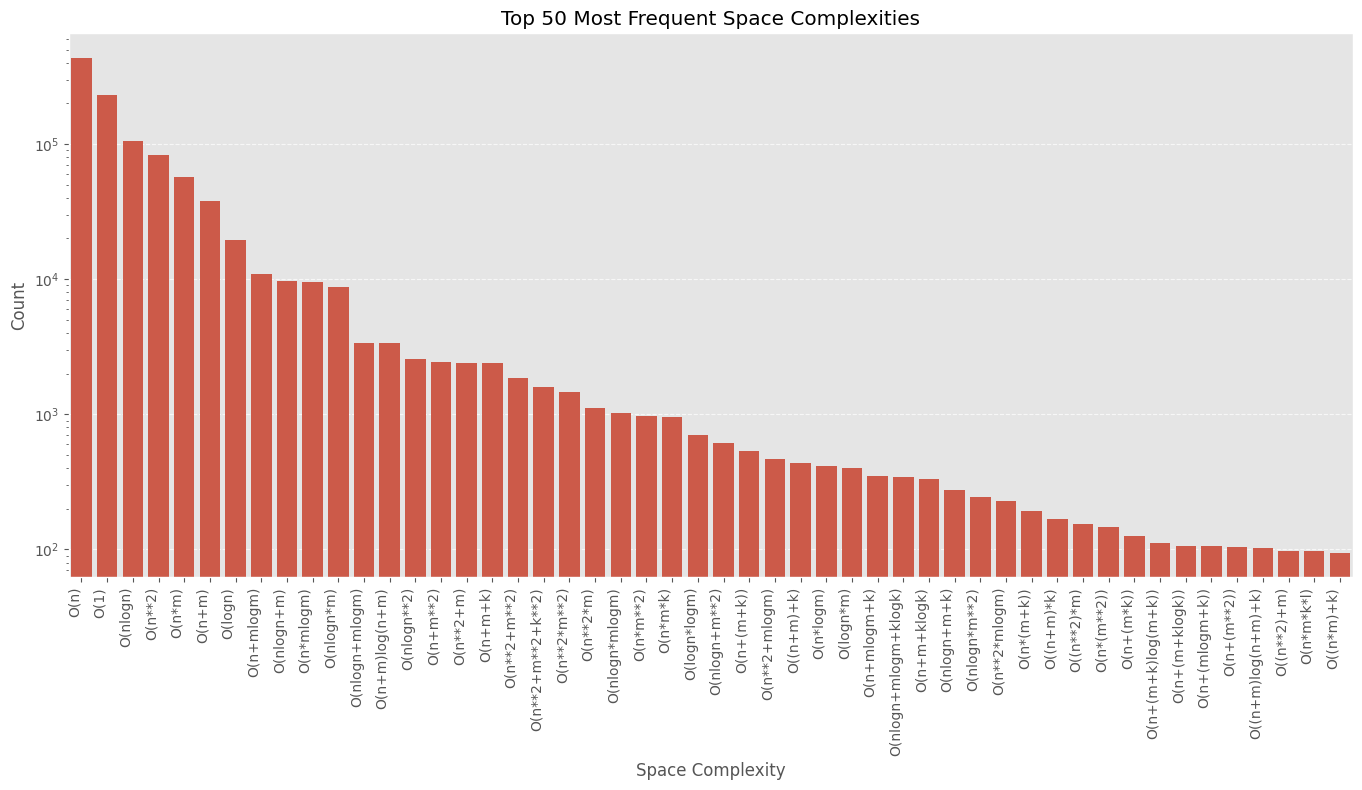

In [ ]:
top_50_time_complexities = time_complexity_counts.head(50)

plt.figure(figsize=(14, 8))
sns.barplot(
    x=top_50_time_complexities.index,
    y=top_50_time_complexities.values,
)
plt.title('Top 50 Most Frequent Time Complexities')
plt.xlabel('Time Complexity')
plt.ylabel('Count')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.yscale('log')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [89]:
# Print the most common space complexities
space_complexity_counts = df_complexity_labels_light_filtered['space_complexity_inferred'].value_counts()
print("Most common space complexities:")
print(space_complexity_counts.head(10))

Most common space complexities:
space_complexity_inferred
O(n)            537972
O(1)            294934
O(n*m)           55585
O(n**2)          37183
O(n+m)           34146
O(logn)          26314
O(nlogn)         14298
O(logn*logm)      9929
O(n+m**2)         4491
O(n**2+m)         3482
Name: count, dtype: int64


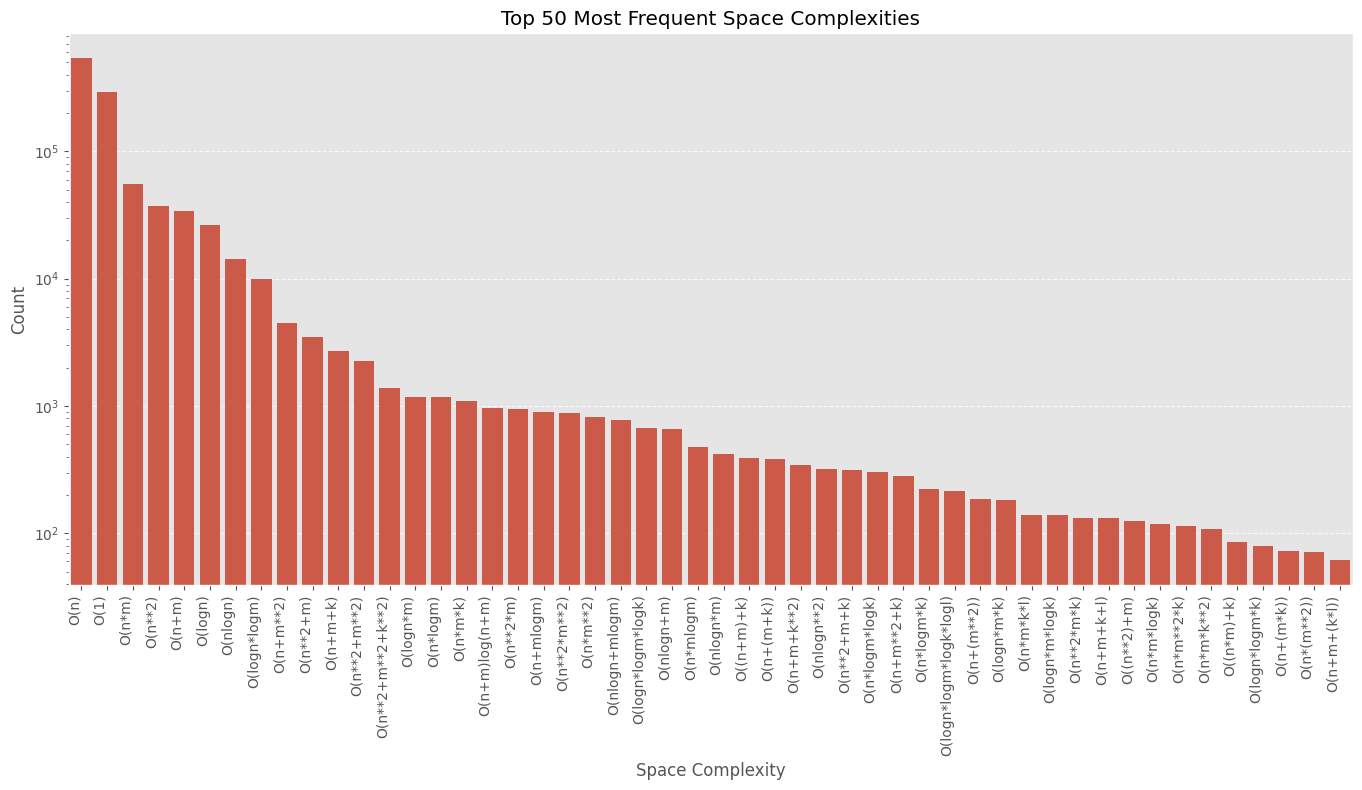

In [97]:
top_50_space_complexities = space_complexity_counts.head(50)

plt.figure(figsize=(14, 8))
sns.barplot(
    x=top_50_space_complexities.index,
    y=top_50_space_complexities.values,
)
plt.title('Top 50 Most Frequent Space Complexities')
plt.xlabel('Space Complexity')
plt.ylabel('Count')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.yscale('log')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [68]:
# Print the most common time complexities and space complexities together
time_space_complexity_counts = df_complexity_labels_light_filtered.groupby(['time_complexity_inferred', 'space_complexity_inferred']).size().reset_index(name='counts')
time_space_complexity_counts = time_space_complexity_counts.sort_values(by='counts', ascending=False)
print("Most common time and space complexities:")
print(time_space_complexity_counts.head(10))

Most common time and space complexities:
     time_complexity_inferred space_complexity_inferred  counts
646                      O(n)                      O(n)  328719
423                      O(1)                      O(1)  174404
639                      O(n)                      O(1)   79135
2131                 O(nlogn)                      O(n)   78020
834                   O(n**2)                      O(n)   42322
1280                   O(n*m)                    O(n*m)   34980
440                      O(1)                      O(n)   25787
840                   O(n**2)                   O(n**2)   20887
424                      O(1)                   O(logn)   16652
1264                   O(n*m)                      O(n)   15444


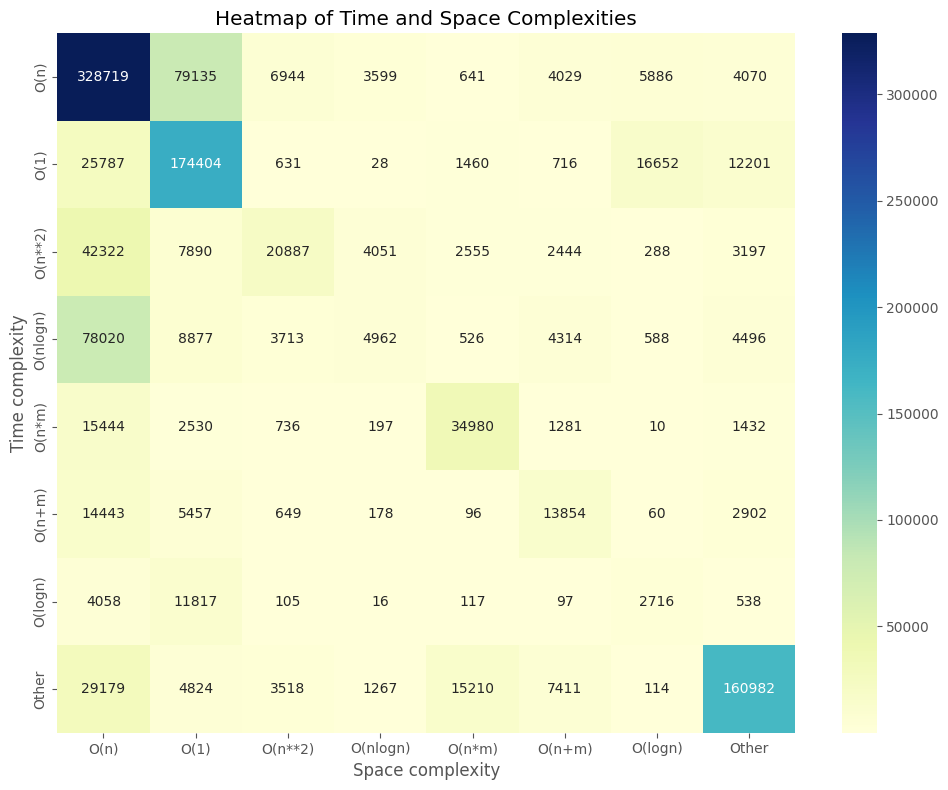

In [59]:
# Create a heatmap of time and space complexities
all_complexities = pd.concat([
    df_complexity_labels_light_filtered['time_complexity_inferred'],
    df_complexity_labels_light_filtered['space_complexity_inferred']
])
top_7_complexities = all_complexities.value_counts().head(7).index.tolist()

df_temp = df_complexity_labels_light.copy()
df_temp['time'] = df_temp['time_complexity_inferred'].apply(lambda x: x if x in top_7_complexities else 'Other')
df_temp['space'] = df_temp['space_complexity_inferred'].apply(lambda x: x if x in top_7_complexities else 'Other')

heatmap_data = df_temp.groupby(['time', 'space']).size().unstack(fill_value=0)

ordered_labels = top_7_complexities + ['Other']
heatmap_data = heatmap_data.reindex(index=ordered_labels, columns=ordered_labels, fill_value=0)

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Heatmap of Time and Space Complexities")
plt.xlabel("Space complexity")
plt.ylabel("Time complexity")
plt.tight_layout()
plt.show()

In [75]:
# Total number of combinations of time and space complexities
print(f"Total number of combinations of time and space complexities:", len(time_space_complexity_counts))
# Maximum number of combinations of time and space complexities
max_combinations = time_space_complexity_counts['counts'].max()
print(f"Maximum number of combinations of time and space complexities:", max_combinations)
# Minimum number of combinations of time and space complexities
min_combinations = time_space_complexity_counts['counts'].min()
print(f"Minimum number of combinations of time and space complexities:", min_combinations)
# Average number of combinations of time and space complexities
average_combinations = time_space_complexity_counts['counts'].mean()
print(f"Average number of combinations of time and space complexities: {average_combinations:.2f}")

Total number of combinations of time and space complexities: 2612
Maximum number of combinations of time and space complexities: 328719
Minimum number of combinations of time and space complexities: 1
Average number of combinations of time and space complexities: 398.77


## CodeForces Tags

In [271]:
def extract_cf_tags(metadata):
    if isinstance(metadata, dict):
        return metadata.get('cf_tags', [])
    return []

# Count the number of unique CF tags
cf_tags_counts = df_problem_and_human_solutions_list_filtered['codeforces_specific_metadata'].apply(extract_cf_tags).explode().value_counts()
cf_tags = cf_tags_counts.index.tolist()
print("Number of unique CF tags:", len(cf_tags_counts))
print("CF tags:", cf_tags)

Number of unique CF tags: 37
CF tags: ['implementation', 'math', 'greedy', '', 'brute force', 'constructive algorithms', 'sortings', 'dp', 'strings', 'number theory', 'binary search', 'data structures', 'two pointers', 'combinatorics', 'graphs', 'dfs and similar', 'geometry', 'bitmasks', '*special', 'trees', 'games', 'dsu', 'shortest paths', 'hashing', 'divide and conquer', 'probabilities', 'expression parsing', 'ternary search', 'matrices', 'string suffix structures', 'meet-in-the-middle', 'flows', 'graph matchings', 'fft', 'schedules', 'chinese remainder theorem', '2-sat']


In [ ]:
# Print number of empty CF tags
empty_cf_tags = cf_tags_counts[cf_tags_counts.index == ''].sum()
print("Number of empty CF tags:", empty_cf_tags)
# Substitue empty CF tags with 'Not defined'
cf_tags_counts = df_problem_and_human_solutions_list_filtered['codeforces_specific_metadata'].apply(extract_cf_tags).explode().replace('', 'Not defined').value_counts()
cf_tags = cf_tags_counts.index.tolist()
print("CF tags:", cf_tags)

Number of empty CF tags: 710
CF tags: ['implementation', 'math', 'greedy', 'Not defined', 'brute force', 'constructive algorithms', 'sortings', 'dp', 'strings', 'number theory', 'binary search', 'data structures', 'two pointers', 'combinatorics', 'graphs', 'dfs and similar', 'geometry', 'bitmasks', '*special', 'trees', 'games', 'dsu', 'shortest paths', 'hashing', 'divide and conquer', 'probabilities', 'expression parsing', 'ternary search', 'matrices', 'string suffix structures', 'meet-in-the-middle', 'flows', 'graph matchings', 'fft', 'schedules', 'chinese remainder theorem', '2-sat']


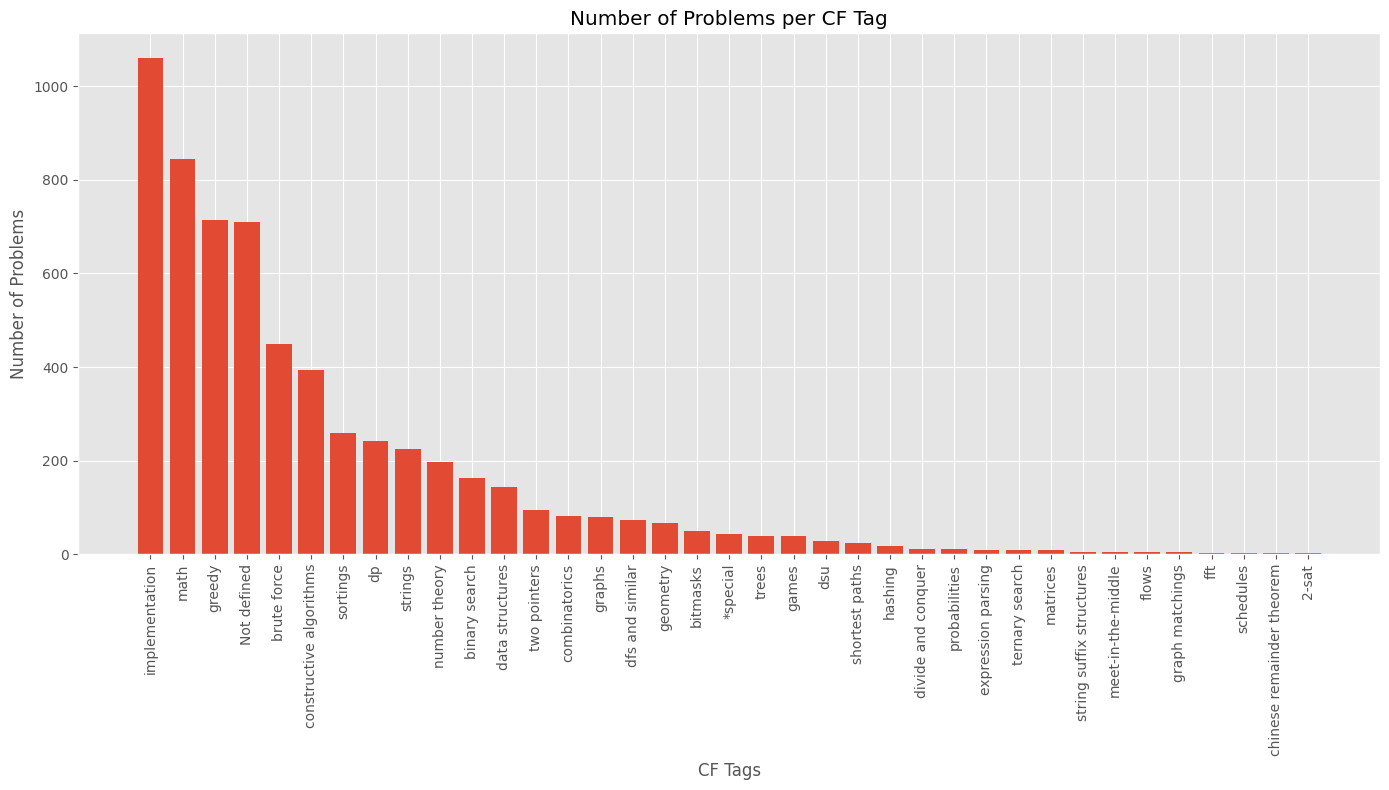

In [287]:
# Plot for each tag the number of problems
plt.figure(figsize=(14, 8))
plt.bar(cf_tags_counts.index, cf_tags_counts.values)
plt.title('Number of Problems per CF Tag')
plt.xlabel('CF Tags')
plt.ylabel('Number of Problems')
plt.xticks(rotation=90, ha='center')
plt.tight_layout() 
plt.show()

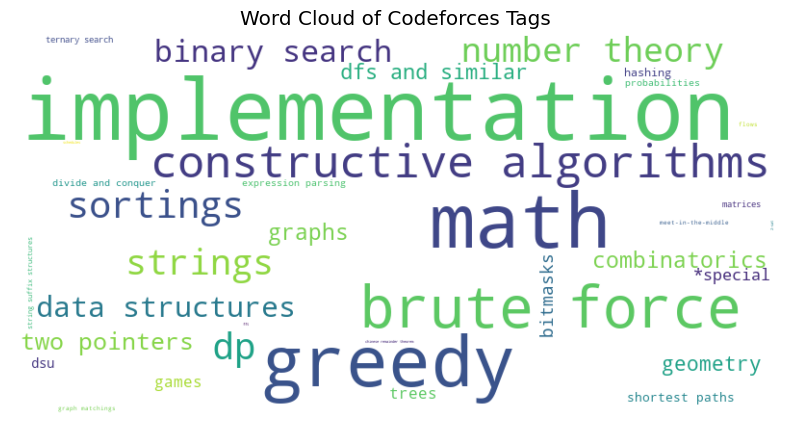

In [288]:
# Create a word cloud of cf_tags in codeforces_specific_metadata column
cf_tags_list = df_problem_and_human_solutions_list_filtered['codeforces_specific_metadata'].apply(extract_cf_tags).explode().dropna()
cf_tags_counter = Counter(cf_tags_list)
worldcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(cf_tags_counter)
plt.figure(figsize=(10, 5))
plt.imshow(worldcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Codeforces Tags")
plt.show()

# Indexing and Search


We can use the text descriptions of the problems to create an index for searching similar problems.

In [107]:
import pyterrier as pt
if not pt.started():
  pt.init()

/var/folders/_p/_zv9pcfx0h9b_ltd79hhdgr00000gn/T/ipykernel_37542/1742394333.py:2: DeprecationWarning: Call to deprecated function (or staticmethod) started. (use pt.java.started() instead) -- Deprecated since version 0.11.0.
  if not pt.started():
Java started and loaded: pyterrier.java, pyterrier.terrier.java [version=5.11 (build: craig.macdonald 2025-01-13 21:29), helper_version=0.0.8]
/var/folders/_p/_zv9pcfx0h9b_ltd79hhdgr00000gn/T/ipykernel_37542/1742394333.py:3: DeprecationWarning: Call to deprecated method pt.init(). Deprecated since version 0.11.0.
java is now started automatically with default settings. To force initialisation early, run:
pt.java.init() # optional, forces java initialisation
  pt.init()


In the following cell the dataset is prepared in order to be ready to work on it according to the python-terrier library input requirements.

In [111]:
descriptions = df_problem_and_human_solutions_list_filtered['description'].dropna().tolist()
texts = [desc.get('text', '') for desc in descriptions]
df_texts = pd.DataFrame(
    [
        ['d'+str(i+1), text] for i, text in enumerate(texts)
    ],
    columns=['docno', 'text']
)
df_texts.head()

,docno,text
0,d1,Xenia has a set of weights and pan scales. Eac...
1,d2,On a strip of land of length n there are k air...
2,d3,Manao has invented a new mathematical term — a...
3,d4,"You have r red, g green and b blue balloons. T..."
4,d5,This is yet another problem dealing with regul...


The first step is to index the whole dataset.

In [112]:
indexer = pt.DFIndexer("./index_contexts", overwrite=True)
index_ref = indexer.index(df_texts['text'], df_texts['docno'])
index_ref.toString()

/var/folders/_p/_zv9pcfx0h9b_ltd79hhdgr00000gn/T/ipykernel_37542/1993086846.py:1: DeprecationWarning: Call to deprecated class DFIndexer. (use pt.terrier.IterDictIndexer().index(dataframe.to_dict(orient='records')) instead) -- Deprecated since version 0.11.0.
  indexer = pt.DFIndexer("./index_contexts", overwrite=True)


'./index_contexts/data.properties'

In [113]:
!ls -lh index_contexts/

total 2960
-rw-r--r--  1 chiaranguyen  staff   195K May  2 08:50 data.direct.bf
-rw-r--r--  1 chiaranguyen  staff    50K May  2 08:50 data.document.fsarrayfile
-rw-r--r--  1 chiaranguyen  staff   190K May  2 08:50 data.inverted.bf
-rw-r--r--  1 chiaranguyen  staff   779K May  2 08:50 data.lexicon.fsomapfile
-rw-r--r--  1 chiaranguyen  staff   1.0K May  2 08:50 data.lexicon.fsomaphash
-rw-r--r--  1 chiaranguyen  staff    36K May  2 08:50 data.lexicon.fsomapid
-rw-r--r--  1 chiaranguyen  staff    59K May  2 08:50 data.meta-0.fsomapfile
-rw-r--r--  1 chiaranguyen  staff    24K May  2 08:50 data.meta.idx
-rw-r--r--  1 chiaranguyen  staff    61K May  2 08:50 data.meta.zdata
-rw-r--r--  1 chiaranguyen  staff   4.1K May  2 08:50 data.properties


We print some information about the index, like the number of documents and the number of terms in the index.

In [115]:
index = pt.IndexFactory.of(index_ref)
print(index.getCollectionStatistics().toString())

Number of documents: 3014
Number of terms: 9281
Number of postings: 171024
Number of fields: 0
Number of tokens: 414933
Field names: []
Positions:   false



We print for each term some statistics, like:
 - `Nt` is the number of unique documents that each term occurs in – this is useful for calculating IDF.
 - `TF` is the total number of occurrences of term in corpus.
 - `maxTF` is the maximum number of occurrences of a term in a single document.

In [122]:
for kv in index.getLexicon(): #kv is a key-value pair
    print(kv.getKey(),": ", kv.getValue().toString())

0 :  term84 Nt=1396 TF=6010 maxTF=237 @{0 0 0}
00 :  term506 Nt=34 TF=68 maxTF=5 @{0 1170 0}
000 :  term716 Nt=275 TF=463 maxTF=9 @{0 1228 4}
0001 :  term2862 Nt=2 TF=2 maxTF=1 @{0 1490 2}
001 :  term3620 Nt=11 TF=16 maxTF=3 @{0 1494 6}
0010 :  term2864 Nt=4 TF=6 maxTF=3 @{0 1517 3}
0011 :  term1047 Nt=10 TF=15 maxTF=2 @{0 1526 3}
002 :  term6141 Nt=1 TF=1 maxTF=1 @{0 1547 4}
0020 :  term6139 Nt=1 TF=1 maxTF=1 @{0 1550 2}
0024 :  term729 Nt=1 TF=1 maxTF=1 @{0 1553 0}
006 :  term4641 Nt=1 TF=1 maxTF=1 @{0 1554 4}
007 :  term4812 Nt=8 TF=13 maxTF=2 @{0 1557 0}
0079 :  term6819 Nt=1 TF=2 maxTF=2 @{0 1572 3}
01 :  term1230 Nt=29 TF=56 maxTF=6 @{0 1575 2}
010 :  term3459 Nt=15 TF=24 maxTF=4 @{0 1625 7}
0100 :  term4798 Nt=2 TF=2 maxTF=1 @{0 1654 4}
0101 :  term568 Nt=13 TF=17 maxTF=3 @{0 1659 4}
011 :  term2248 Nt=9 TF=11 maxTF=2 @{0 1683 2}
0110 :  term566 Nt=10 TF=12 maxTF=2 @{0 1702 2}
0111 :  term2865 Nt=4 TF=5 maxTF=2 @{0 1719 4}
0112 :  term6250 Nt=1 TF=1 maxTF=1 @{0 1729 1}
012 :  te

For example, the term 'sort' occurs in 81 documents, with a total of 224 occurrences, and the maximum number of occurrences in a single document is 14.

In [127]:
index.getLexicon()['sort'].toString()

'term1036 Nt=81 TF=224 maxTF=14 @{0 164384 7}'

We can see also how many times the word 'sort' is used in each context that it occurs in. It's reported also the length of each context.

In [ ]:
pointer = index.getLexicon()["sort"]
for posting in index.getInvertedIndex().getPostings(pointer):
    print(f'{posting.toString()} doclen = {posting.getDocumentLength()}')

ID(62) TF(4) doclen = 187
ID(66) TF(2) doclen = 190
ID(68) TF(4) doclen = 93
ID(107) TF(1) doclen = 76
ID(138) TF(1) doclen = 56
ID(188) TF(1) doclen = 71
ID(196) TF(3) doclen = 106
ID(217) TF(2) doclen = 131
ID(240) TF(1) doclen = 109
ID(326) TF(2) doclen = 24
ID(340) TF(8) doclen = 104
ID(360) TF(4) doclen = 286
ID(422) TF(2) doclen = 57
ID(438) TF(2) doclen = 202
ID(443) TF(1) doclen = 187
ID(533) TF(2) doclen = 59
ID(604) TF(1) doclen = 100
ID(668) TF(4) doclen = 234
ID(676) TF(2) doclen = 324
ID(685) TF(1) doclen = 190
ID(733) TF(2) doclen = 136
ID(762) TF(2) doclen = 96
ID(767) TF(2) doclen = 173
ID(868) TF(1) doclen = 184
ID(896) TF(6) doclen = 202
ID(975) TF(1) doclen = 184
ID(1001) TF(3) doclen = 95
ID(1023) TF(3) doclen = 112
ID(1036) TF(2) doclen = 106
ID(1040) TF(13) doclen = 164
ID(1055) TF(9) doclen = 298
ID(1060) TF(1) doclen = 175
ID(1127) TF(8) doclen = 149
ID(1202) TF(1) doclen = 248
ID(1205) TF(4) doclen = 158
ID(1227) TF(2) doclen = 95
ID(1293) TF(3) doclen = 174
ID

### TF-IDF Index Search
We can use the TF-IDF index to search for similar problems. 

In [132]:
query = "How can I sort an array"

br = pt.BatchRetrieve(index, wmodel="TF_IDF")
br.search(query)

/var/folders/_p/_zv9pcfx0h9b_ltd79hhdgr00000gn/T/ipykernel_37542/1621297601.py:3: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  br = pt.BatchRetrieve(index, wmodel="TF_IDF")


,qid,docid,docno,rank,score,query
0,1,1040,d1041,0,10.952940,How can I sort an array
1,1,1127,d1128,1,10.699319,How can I sort an array
2,1,340,d341,2,10.362748,How can I sort an array
3,1,2715,d2716,3,10.146678,How can I sort an array
4,1,1713,d1714,4,9.917983,How can I sort an array
...,...,...,...,...,...,...
995,1,5,d6,995,1.140711,How can I sort an array
996,1,984,d985,996,1.140711,How can I sort an array
997,1,2320,d2321,997,1.140711,How can I sort an array
998,1,2421,d2422,998,1.140711,How can I sort an array


In [131]:
most_relevant_result = df_texts.loc[df_texts['docno'] == 'd1041', 'text'].values[0]
print(most_relevant_result)

[Thanos sort](https://codegolf.stackexchange.com/questions/182221/implement-the-thanos-sorting-algorithm) is a supervillain sorting algorithm, which works as follows: if the array is not sorted, snap your fingers* to remove the first or the second half of the items, and repeat the process.

Given an input array, what is the size of the longest sorted array you can obtain from it using Thanos sort?

*Infinity Gauntlet required.

Input

The first line of input contains a single number n (1 ≤ n ≤ 16) — the size of the array. n is guaranteed to be a power of 2.

The second line of input contains n space-separated integers a_i (1 ≤ a_i ≤ 100) — the elements of the array.

Output

Return the maximal length of a sorted array you can obtain using Thanos sort. The elements of the array have to be sorted in non-decreasing order.

Examples

Input


4
1 2 2 4


Output


4


Input


8
11 12 1 2 13 14 3 4


Output


2


Input


4
7 6 5 4


Output


1

Note

In the first example the array is already 

In [133]:
queries = pd.DataFrame([["query1", "list"], ["query2", "highest"], ["query3", "number"]], columns=["qid", "query"])
br(queries)

,qid,docid,docno,rank,score,query
0,query1,2805,d2806,0,5.147456,list
1,query1,2389,d2390,1,5.042130,list
2,query1,1018,d1019,2,4.963281,list
3,query1,240,d241,3,4.934484,list
4,query1,2613,d2614,4,4.906904,list
...,...,...,...,...,...,...
1143,query3,246,d247,995,1.041843,number
1144,query3,233,d234,996,1.040734,number
1145,query3,553,d554,997,1.040734,number
1146,query3,2984,d2985,998,1.040734,number


In [134]:
most_relevant_result = df_texts.loc[df_texts['docno'] == 'd2806', 'text'].values[0]
print(most_relevant_result)

Two players A and B have a list of n integers each. They both want to maximize the subtraction between their score and their opponent's score. 

In one turn, a player can either add to his score any element from his list (assuming his list is not empty), the element is removed from the list afterward. Or remove an element from his opponent's list (assuming his opponent's list is not empty).

Note, that in case there are equal elements in the list only one of them will be affected in the operations above. For example, if there are elements \{1, 2, 2, 3\} in a list and you decided to choose 2 for the next turn, only a single instance of 2 will be deleted (and added to the score, if necessary). 

The player A starts the game and the game stops when both lists are empty. Find the difference between A's score and B's score at the end of the game, if both of the players are playing optimally.

Optimal play between two players means that both players choose the best possible strategy to achie

### BM25 Index Search
We perform the same search using the BM25 index to see if there are any differences in the results.

In [135]:
query = "How can I sort an array"

br = pt.BatchRetrieve(index, wmodel="BM25")
br.search(query)

/var/folders/_p/_zv9pcfx0h9b_ltd79hhdgr00000gn/T/ipykernel_37542/2031488563.py:3: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  br = pt.BatchRetrieve(index, wmodel="BM25")


,qid,docid,docno,rank,score,query
0,1,1040,d1041,0,16.281132,How can I sort an array
1,1,340,d341,1,16.221999,How can I sort an array
2,1,1127,d1128,2,15.993463,How can I sort an array
3,1,2715,d2716,3,15.403267,How can I sort an array
4,1,2124,d2125,4,15.359915,How can I sort an array
...,...,...,...,...,...,...
995,1,1364,d1365,995,-0.625698,How can I sort an array
996,1,1478,d1479,996,-0.625698,How can I sort an array
997,1,2155,d2156,997,-0.626064,How can I sort an array
998,1,2897,d2898,998,-0.626935,How can I sort an array


In [137]:
queries = pd.DataFrame([["query1", "list"], ["query2", "highest"], ["query3", "number"]], columns=["qid", "query"])
br(queries)

,qid,docid,docno,rank,score,query
0,query1,2805,d2806,0,9.195029,list
1,query1,2389,d2390,1,9.006882,list
2,query1,1018,d1019,2,8.866031,list
3,query1,240,d241,3,8.814590,list
4,query1,2613,d2614,4,8.765324,list
...,...,...,...,...,...,...
1143,query3,768,d769,995,-2.753890,number
1144,query3,1036,d1037,996,-2.753890,number
1145,query3,1410,d1411,997,-2.753890,number
1146,query3,1430,d1431,998,-2.753890,number


In [ ]:
lexicon = index.getLexicon()
term_frequencies = []

for kv in lexicon:
    term_frequencies.append(kv.getValue().getDocumentFrequency())

plt.figure(figsize=(10,6))
plt.hist(term_frequencies, bins=100, log=True)
plt.title("Distribuzione Document Frequency dei Termini")
plt.xlabel("Document Frequency")
plt.ylabel("Numero di Termini (log scale)")
plt.show()

## Problem Name

In [177]:
# Clean the problem names
problem_name_counts = df_problem_and_human_solutions_list_filtered['problem_name'].apply(
    lambda x: ' '.join(x.split(' ')[1:]) if ' ' in x else x
).value_counts()

# Count the number of duplicate problem names
duplicate_problem_names = problem_name_counts[problem_name_counts > 1]

print("Number of unique clean problem names:", len(problem_name_counts))
print("Number of duplicated clean problem names:", len(duplicate_problem_names))
print("Duplicated problem names:")
print(duplicate_problem_names[duplicate_problem_names > 1].index.tolist())

Number of unique clean problem names: 2891
Number of duplicated clean problem names: 111
Duplicated problem names:
['Queue', 'Exams', 'Make Them Equal', 'Cards', 'Game', 'Coins', 'Card Game', 'Phone Numbers', 'Candies', 'Triangle', 'k-Amazing Numbers', 'Pythagorean Triples', 'Common Divisors', 'Drazil and His Happy Friends', 'Divisibility', 'Quiz', 'Dreamoon and Sums', 'Rectangle', 'Plus and Square Root', 'Vacations', "Mr. Kitayuta's Gift", 'Tennis Championship', 'Suit and Tie', 'Lucky Numbers', 'Little Artem and Grasshopper', 'Permutation', 'Treasure Hunt', 'Division', 'Connect Three', 'Appleman and Toastman', 'Special Permutation', "Hilbert's Hotel", 'Linova and Kingdom', 'Chain Reaction', 'Extreme Subtraction', 'Prefix Sum Primes', 'Binary String Reconstruction', 'Multiplication Table', 'Photo of The Sky', 'Drazil and Factorial', 'Save Energy!', 'Boxes Packing', 'Domino for Young', 'Oh Those Palindromes', 'Long Beautiful Integer', 'Watchmen', 'Aerodynamic', 'Fox And Names', "Gerald'

In [ ]:
# Drop data_source column
df_problem_and_human_solutions_list = df_problem_and_human_solutions_list.drop(columns=['data_source'])

In [ ]:
# Drop source_specific_limits column
df_problem_and_human_solutions_list = df_problem_and_human_solutions_list.drop(columns=['source_specific_limits'])